In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
# import seaborn as sns
import librosa
import librosa.display
import IPython


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from tqdm import tqdm


In [2]:
Crema_Path='../input/speech-emotion-recognition-en/Crema/'

In [3]:
!pip install audiomentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.3/214.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 68.8 MB/s eta 0:00:00:00:01
  Attempting uninstall: librosa
    Found existing installation: librosa 0.10.0.post2
    Uninstalling librosa-0.10.0.post2:
      Successfully uninstalled librosa-0.10.0.post2


In [3]:
crema = []
for wav in sorted(os.listdir(Crema_Path)):
    emotion = wav.partition(".wav")[0].split('_')
    if emotion[2] == 'SAD':
        crema.append((emotion[0], 'sad', Crema_Path+'/'+wav, emotion[1], emotion[3]))
    elif emotion[2] == 'ANG':
        crema.append((emotion[0], 'angry', Crema_Path+'/'+wav, emotion[1], emotion[3]))
    elif emotion[2] == 'DIS':
        crema.append((emotion[0], 'disgust', Crema_Path+'/'+wav, emotion[1], emotion[3]))
    elif emotion[2] == 'FEA':
        crema.append((emotion[0], 'fear', Crema_Path+'/'+wav, emotion[1], emotion[3]))
    elif emotion[2] == 'HAP':
        crema.append((emotion[0], 'happy', Crema_Path+'/'+wav, emotion[1], emotion[3]))
    elif emotion[2] == 'NEU':
        crema.append((emotion[0], 'neutral', Crema_Path+'/'+wav, emotion[1], emotion[3]))
    else:
        crema.append((emotion[0], 'unknown', Crema_Path+'/'+wav, emotion[1], emotion[3]))

df = pd.DataFrame.from_records(crema, columns=['Person', 'Emotion', 'File_Path', 'sentence','intensity'])
df.head()


Person  Emotion                                          File_Path sentence  \
0   1001    angry  ../input/speech-emotion-recognition-en/Crema//...      DFA   
1   1001  disgust  ../input/speech-emotion-recognition-en/Crema//...      DFA   
2   1001     fear  ../input/speech-emotion-recognition-en/Crema//...      DFA   
3   1001    happy  ../input/speech-emotion-recognition-en/Crema//...      DFA   
4   1001  neutral  ../input/speech-emotion-recognition-en/Crema//...      DFA   

  intensity  
0        XX  
1        XX  
2        XX  
3        XX  
4        XX

In [4]:
df.File_Path[0]

'../input/speech-emotion-recognition-en/Crema//1001_DFA_ANG_XX.wav'

In [5]:
from sklearn.preprocessing import LabelEncoder
# Create a LabelEncoder 
encoder = LabelEncoder()
# Fit the encoder on the column and transform the values
df['Emotion_encoded'] = encoder.fit_transform(df['Emotion'])

# Get the mapping between original labels and encoded values
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
label_mapping

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5}

In [7]:
df

Person  Emotion                                          File_Path  \
0      1001    angry  ../input/speech-emotion-recognition-en/Crema//...   
1      1001  disgust  ../input/speech-emotion-recognition-en/Crema//...   
2      1001     fear  ../input/speech-emotion-recognition-en/Crema//...   
3      1001    happy  ../input/speech-emotion-recognition-en/Crema//...   
4      1001  neutral  ../input/speech-emotion-recognition-en/Crema//...   
...     ...      ...                                                ...   
7437   1091  disgust  ../input/speech-emotion-recognition-en/Crema//...   
7438   1091     fear  ../input/speech-emotion-recognition-en/Crema//...   
7439   1091    happy  ../input/speech-emotion-recognition-en/Crema//...   
7440   1091  neutral  ../input/speech-emotion-recognition-en/Crema//...   
7441   1091      sad  ../input/speech-emotion-recognition-en/Crema//...   

     sentence intensity  Emotion_encoded  
0         DFA        XX                0  
1         DFA        XX                1  
2         DFA        XX                2  
3         DFA        XX                3  
4         DFA        XX                4  
...       ...       ...              ...  
7437      WSI        XX                1  
7438      WSI        XX                2  
7439      WSI        XX                3  
7440      WSI        XX                4  
7441      WSI        XX                5  

[7442 rows x 6 columns]

In [242]:
#train test split
from sklearn.model_selection import train_test_split
# Perform the train-test split (70% train, 30% test & validation)
X_train, X_testAndVal, y_train, y_testAndVal = train_test_split(df['File_Path'], df['Emotion_encoded'], test_size=0.3, stratify=df['Emotion_encoded'], random_state=42)

# Perform the train-validation split (50% test, 50% validation) (15%)
X_val, X_test, y_val, y_test = train_test_split(X_testAndVal, y_testAndVal, test_size=0.5, stratify=y_testAndVal, random_state=42)

# Print the sizes of each split
print("Train set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))



Train set size: 5209
Validation set size: 1116
Test set size: 1117


In [243]:
X_train=X_train.reset_index().drop(columns=["index"])
y_train=y_train.reset_index().drop(columns=["index"])

X_test=X_test.reset_index().drop(columns=["index"])
y_test=y_test.reset_index().drop(columns=["index"])

X_val=X_val.reset_index().drop(columns=["index"])
y_val=y_val.reset_index().drop(columns=["index"])


In [9]:
df['Emotion'].unique()

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad'],
      dtype=object)

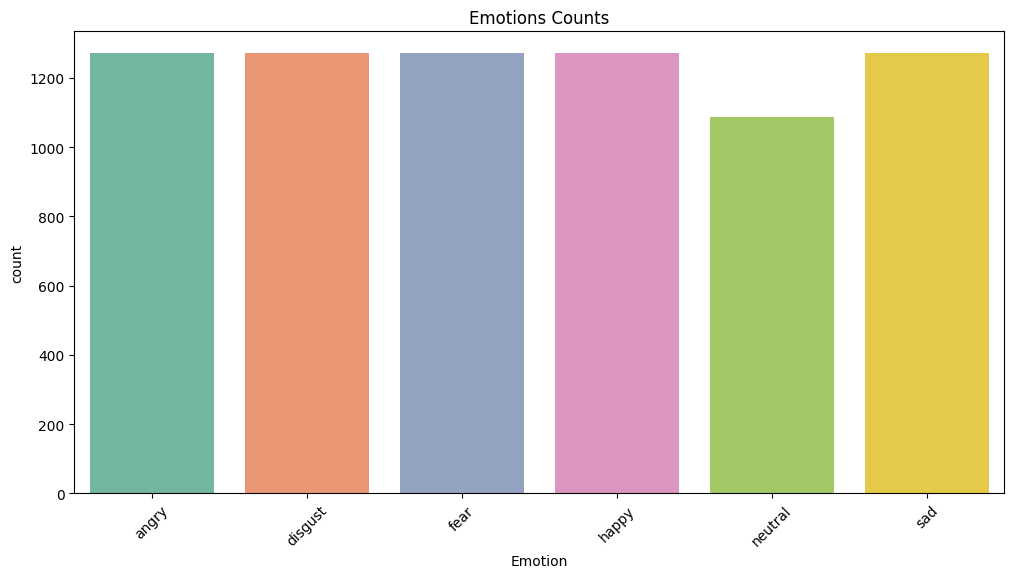

In [10]:
import seaborn as sns
plt.figure(figsize=(12,6))
plt.title('Emotions Counts')
emotions=sns.countplot(x='Emotion',data=df,palette='Set2')
emotions.set_xticklabels(emotions.get_xticklabels(),rotation=45)
plt.show()

In [11]:
def wave_plot(data,sr,emotion):
    plt.figure(figsize=(12,5))
    plt.title(f'{emotion} emotion for waveplot',size=17)
    librosa.display.waveshow(y=data,sr=sr)

In [12]:
emotion_names=df['Emotion'].unique()

# Plotting and listening to a sample of each Emotion


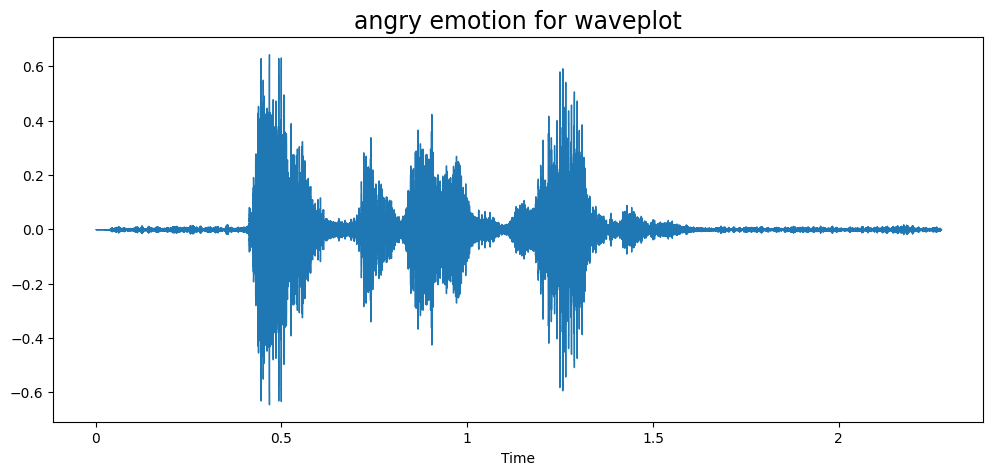

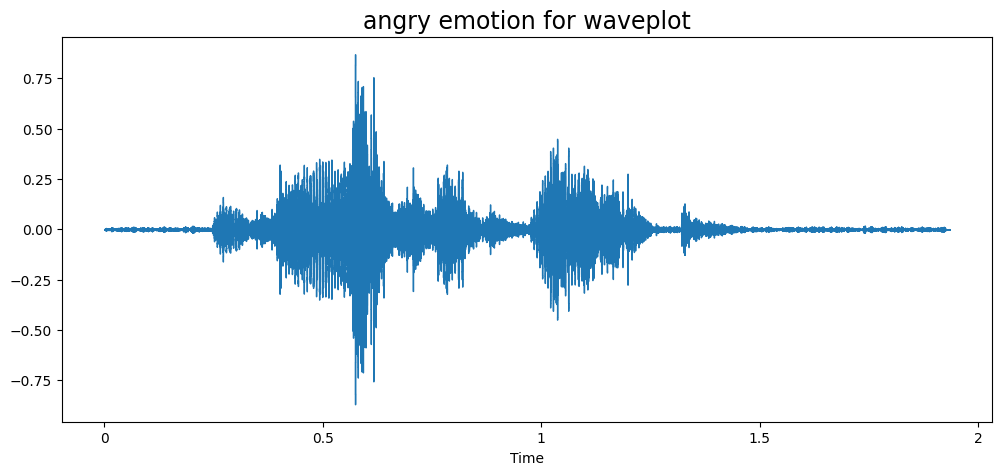

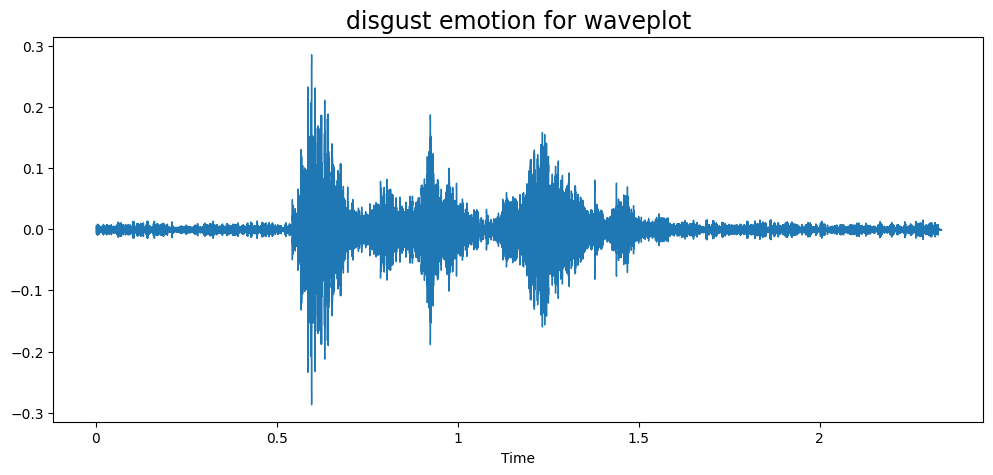

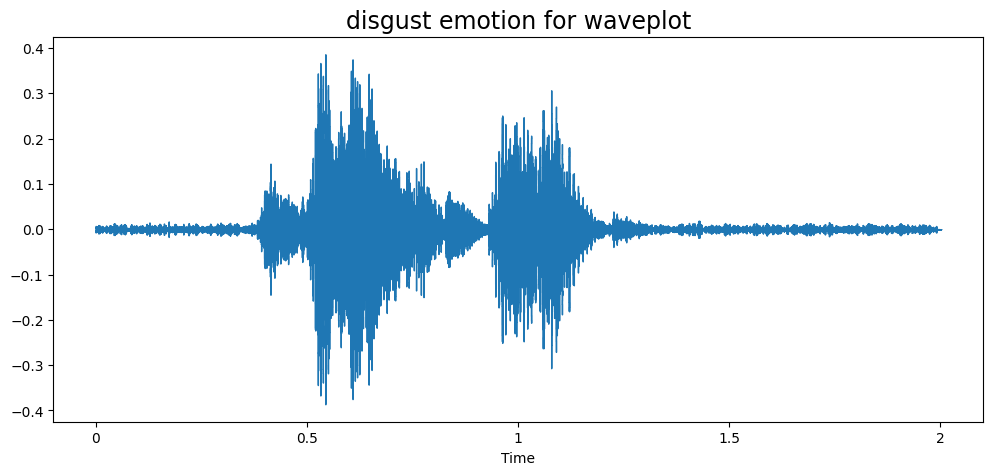

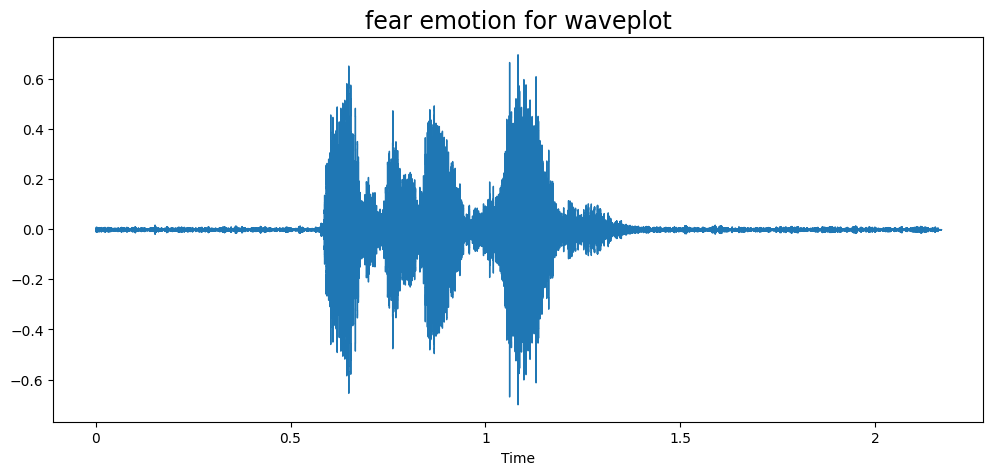

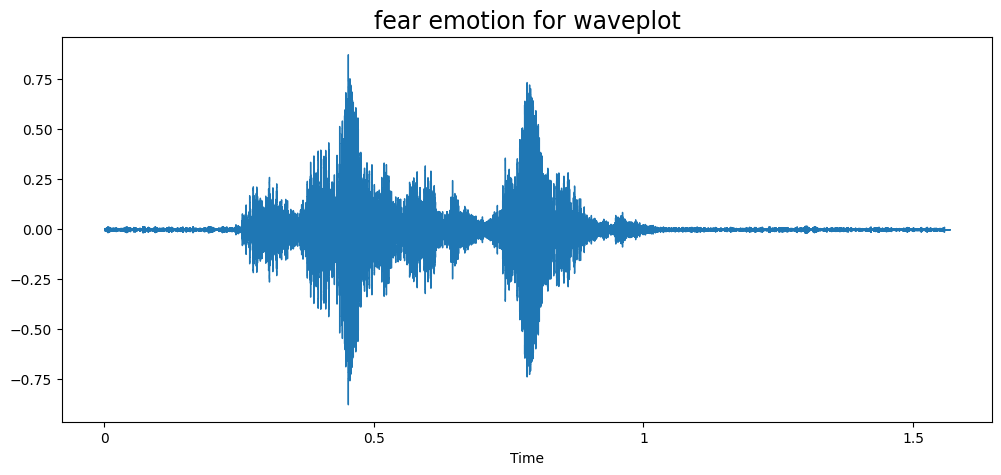

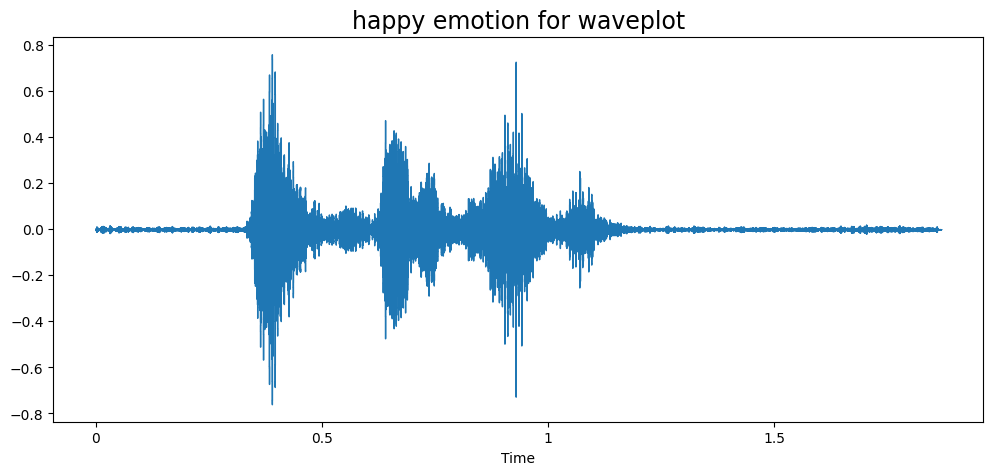

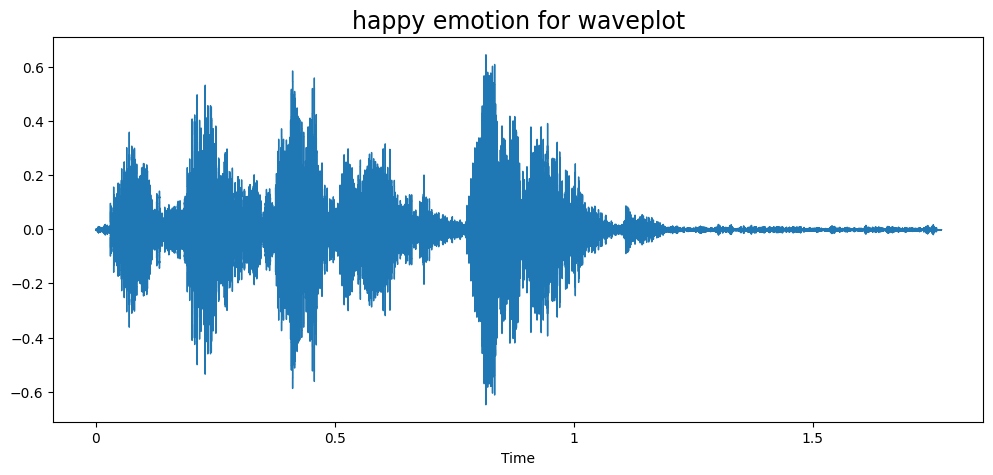

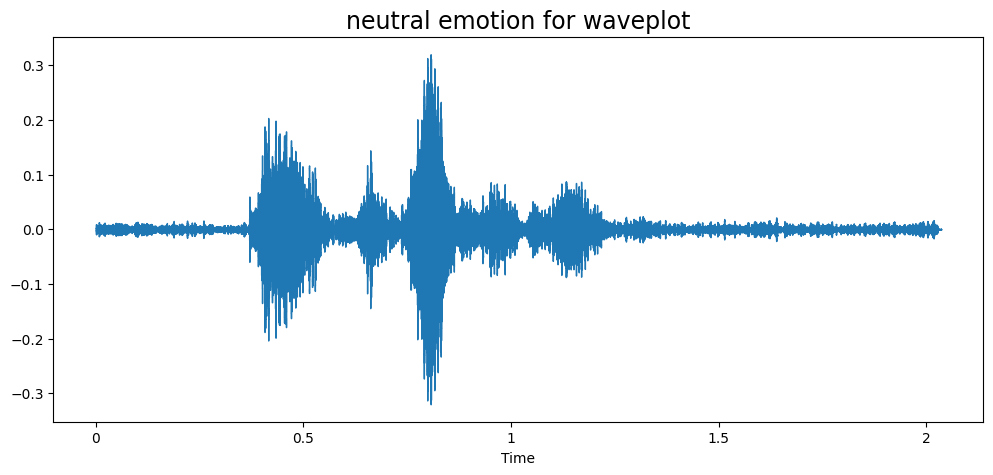

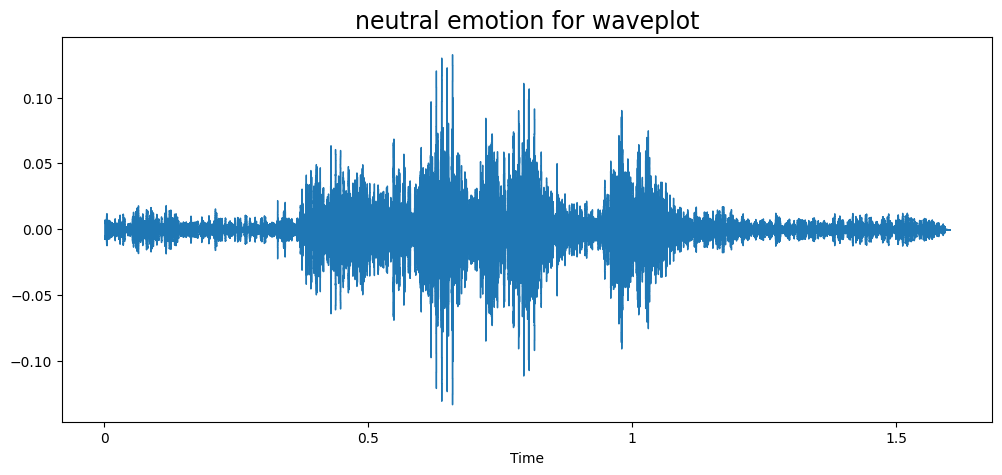

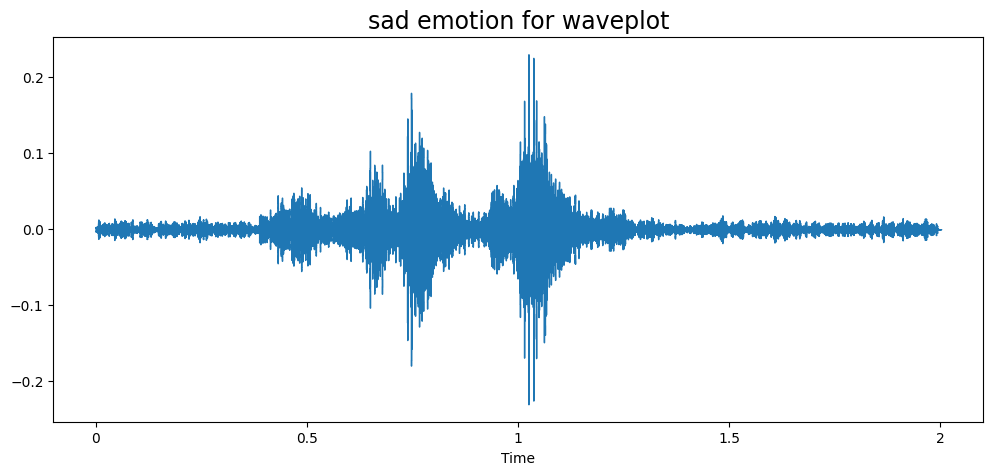

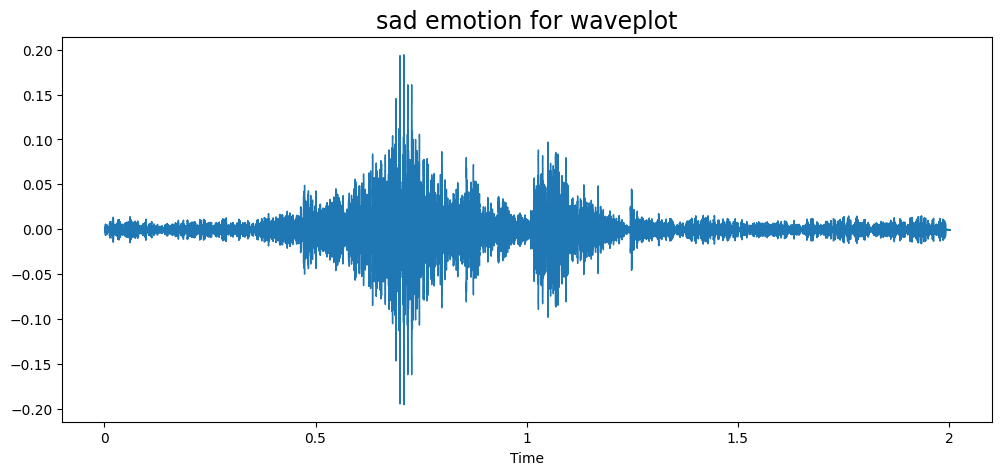

In [15]:
audio_path=[]
for emotion in emotion_names:
    paths=np.array(df['File_Path'][df['Emotion']==emotion])[:2]
    for path in paths:
        data,sr=librosa.load(path)
        wave_plot(data,sr,emotion)
        audio_path.append(path)

In [12]:
i = 0
for emotion in emotion_names:
    print(f'{emotion} Audio Sample\n')
    IPython.display.display(IPython.display.Audio(audio_path[i]))
    print(f'{emotion} Audio Sample\n')
    IPython.display.display(IPython.display.Audio(audio_path[i+1]))
    i+=2

angry Audio Sample



angry Audio Sample



disgust Audio Sample



disgust Audio Sample



fear Audio Sample



fear Audio Sample



happy Audio Sample



happy Audio Sample



neutral Audio Sample



neutral Audio Sample



sad Audio Sample



sad Audio Sample



# Data analysis

**Choosing parameters for melspectogram**

For distinguishing between different emotional states in voice recordings (such as angry, sad, and happy), a suitable value for `n_fft` can vary depending on the specific characteristics of the audio data and the analysis requirements. Here are some considerations to help you choose an appropriate `n_fft` value:

1. Emotional vocal characteristics: Different emotional states can manifest in various ways in the voice, including changes in pitch, intonation, spectral balance, and energy distribution. The relevant emotional cues may span a range of frequencies. It's important to select an `n_fft` value that captures the relevant frequency components related to emotional characteristics.

2. Spectral features: Emotional content in voice recordings can be reflected in the spectral content. Larger `n_fft` values allow for better frequency resolution, potentially capturing more subtle spectral details that differentiate emotional states. However, keep in mind that increasing `n_fft` also increases computational requirements.

3. Duration of emotional cues: Consider the duration of the emotional cues you expect to capture. If emotional information is expressed in short temporal segments, a smaller `n_fft` might be sufficient. On the other hand, if emotional cues extend over longer durations, a larger `n_fft` could be beneficial to capture more comprehensive spectral information.

4. Computational resources: Take into account the available computational resources for your analysis. Larger `n_fft` values require more processing power and memory. Ensure that your chosen `n_fft` value is computationally feasible given the constraints of your system.

While an exact value of `n_fft` cannot be determined without specific knowledge of your dataset, a value in the range of 1024 to 4096 is commonly used for speech-related analysis tasks. You can start with a default value like 2048 and adjust it based on the characteristics of your voice data and the results you obtain. It may be helpful to experiment with different `n_fft` values to find the optimal balance between capturing relevant spectral features and computational efficiency for your specific task of distinguishing between angry, sad, and happy voices.

**hop_length**

As for the specific value of hop_length, it's common to set it to a fraction of n_fft to achieve a good balance between time and frequency resolution. A typical choice is to set hop_length to half (hop_length = n_fft // 2) or a quarter (hop_length = n_fft // 4) of the n_fft value. In this case, a hop_length value of 1024 (hop_length = 2048 // 2) can be a reasonable starting point.

**n_mels**

A common practice is to set n_mels to a value between 40 and 128. The choice within this range depends on the complexity of the audio data and the specific requirements of your emotion recognition task. It's generally recommended to start with a value around 64 and adjust it based on the characteristics of your data and the performance of your models.

In [16]:
def melspectogram_wave_plot(path,emotion):
    y,sr = librosa.load(path)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=2048 ,hop_length=1024)

    S_dB = librosa.power_to_db(S)
    
    fig, ax = plt.subplots()
    img = librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=sr, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title=f'Mel-frequency spectrogram for {emotion} sound')

In [17]:
emotion_names

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad'],
      dtype=object)

In [18]:
y,sr = librosa.load(audio_path[3])
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=2048 ,hop_length=1024)
S_dB = librosa.power_to_db(S)

In [19]:
S_dB.shape

(128, 44)

In [20]:
S_dB[:,0]

array([-26.576567, -26.328033, -22.864286, -26.24728 , -18.40502 ,
       -18.55914 , -15.448141, -12.347979, -11.699914, -14.338638,
       -21.77909 , -27.773611, -29.266933, -26.00467 , -34.70802 ,
       -33.251278, -32.67204 , -30.650597, -32.716064, -33.940395,
       -32.773174, -32.998596, -32.22241 , -33.563377, -33.403027,
       -26.98938 , -26.957024, -32.458107, -36.105186, -43.61428 ,
       -37.49581 , -34.48645 , -35.32789 , -36.166824, -35.089996,
       -35.637802, -37.926556, -40.18356 , -46.359478, -38.1138  ,
       -40.980797, -39.805275, -39.048847, -40.050804, -37.90377 ,
       -39.350296, -40.2022  , -42.685963, -41.384796, -40.62241 ,
       -39.154613, -42.66626 , -48.069572, -48.769478, -44.67403 ,
       -42.886524, -45.46045 , -40.752243, -41.279312, -39.1743  ,
       -38.435715, -39.85041 , -41.848343, -46.64502 , -39.88093 ,
       -44.83208 , -47.50184 , -47.913433, -46.793957, -46.220505,
       -42.120625, -43.67102 , -47.320095, -44.647774, -45.392

In [21]:
S_dB[:,]

array([[-26.576567, -26.269592, -33.407444, ..., -29.977364, -27.556843,
        -30.629639],
       [-26.328033, -20.978308, -31.365833, ..., -26.043587, -24.347073,
        -31.516033],
       [-22.864286, -17.791077, -19.386158, ..., -18.876392, -14.418664,
        -24.485891],
       ...,
       [-58.7415  , -58.7415  , -58.7415  , ..., -58.7415  , -58.7415  ,
        -58.7415  ],
       [-58.7415  , -58.7415  , -58.7415  , ..., -58.7415  , -58.7415  ,
        -58.7415  ],
       [-58.7415  , -58.7415  , -58.7415  , ..., -58.7415  , -58.7415  ,
        -58.7415  ]], dtype=float32)

In [22]:
y.shape

(44145,)

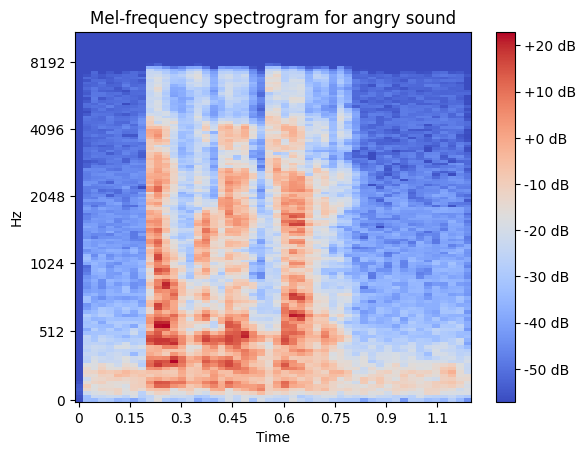

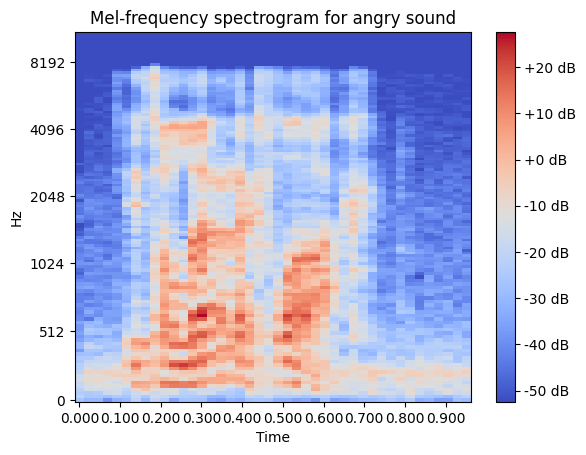

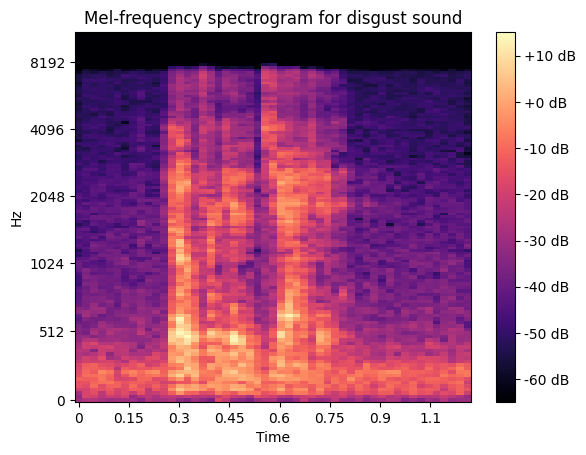

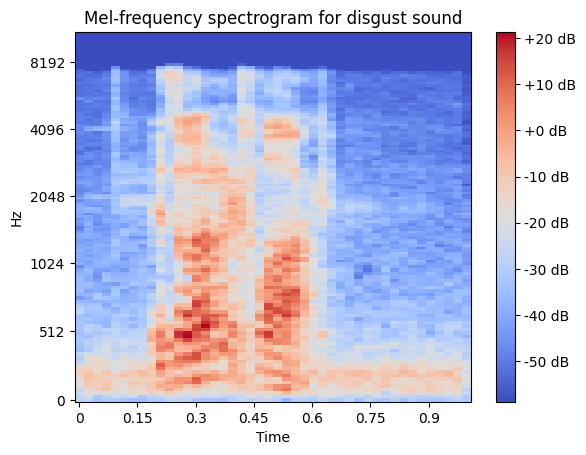

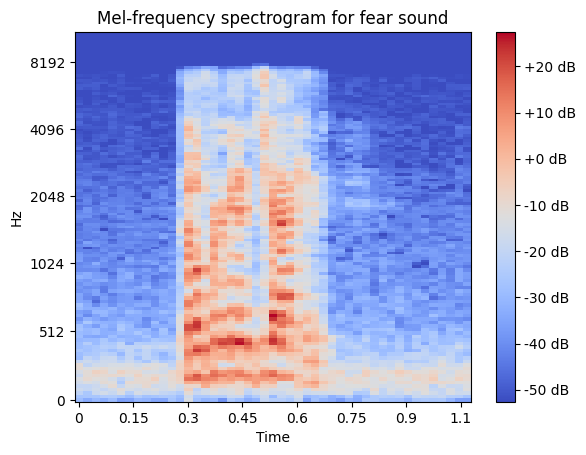

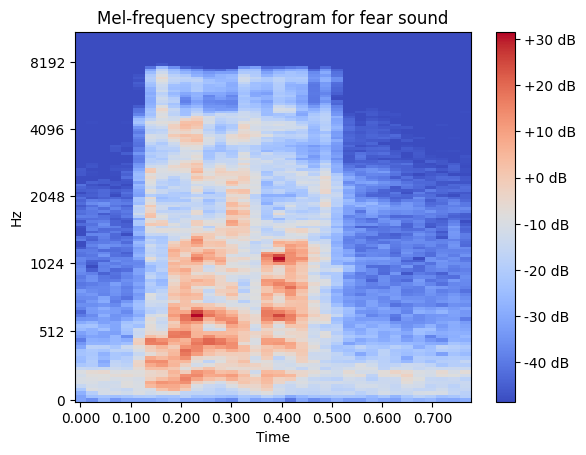

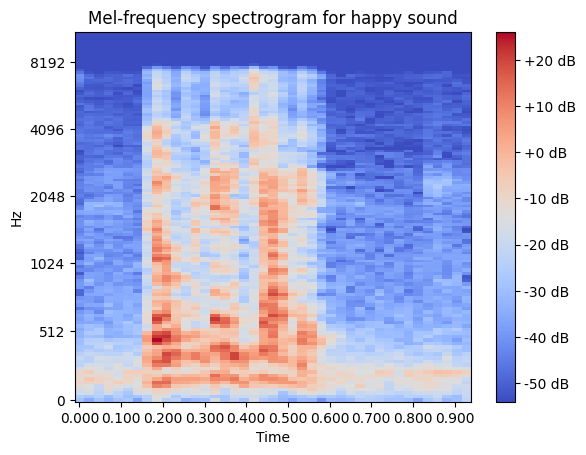

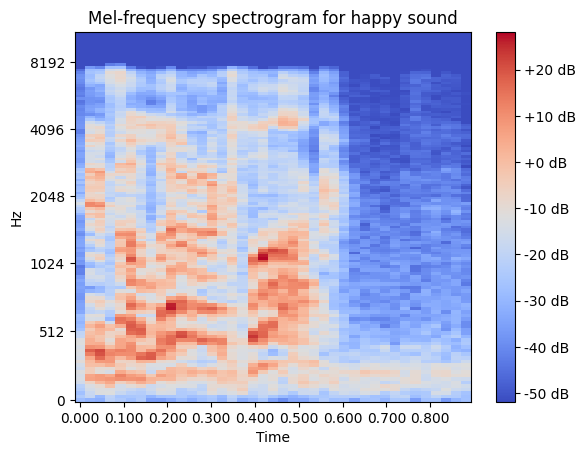

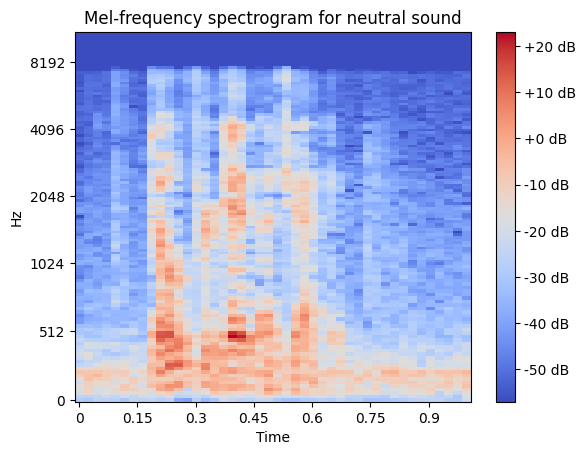

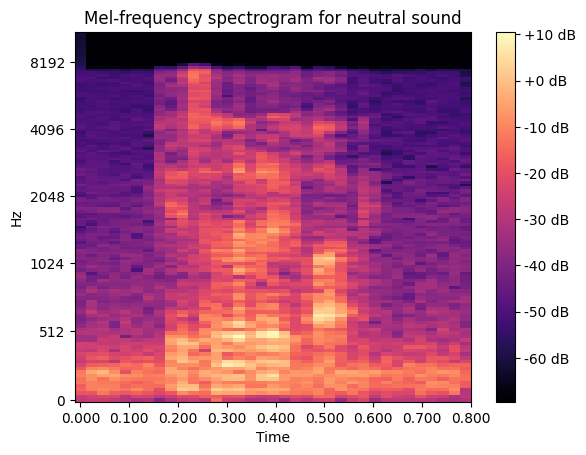

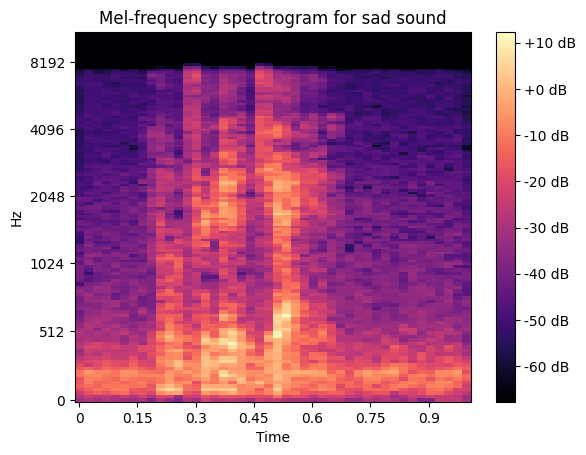

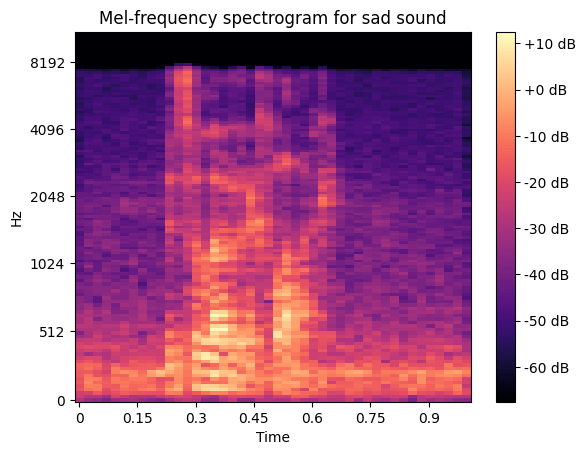

In [23]:
for idx in range(0, len(audio_path), 2):
    melspectogram_wave_plot(audio_path[idx],emotion_names[idx//2])
    melspectogram_wave_plot(audio_path[idx+1],emotion_names[idx//2])

In [24]:
guy1_df=df[df['Person']=="1001"]

guy1=np.array(guy1_df['File_Path'])

angry


disgust


fear


happy


neutral


sad


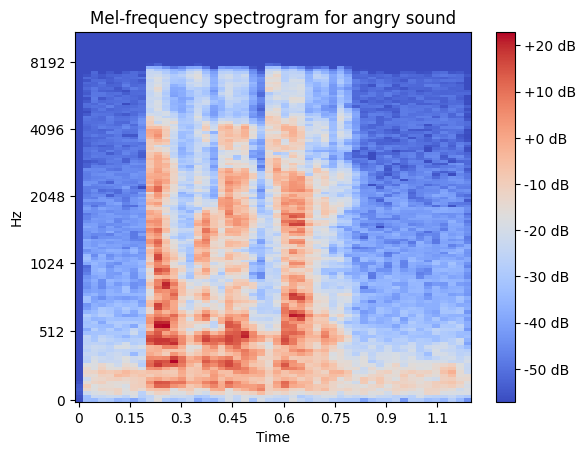

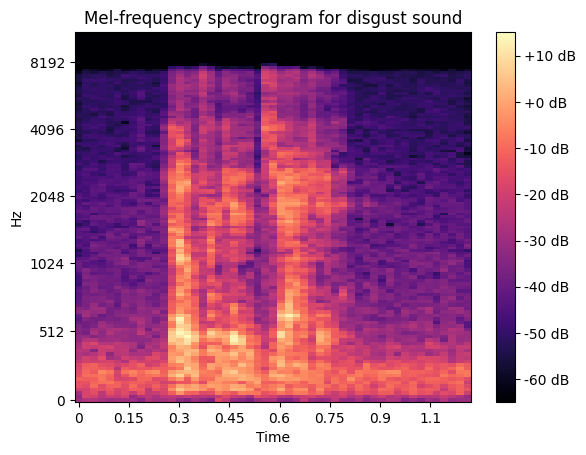

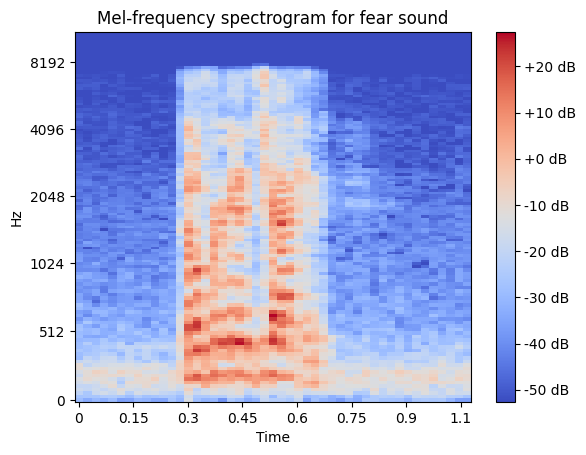

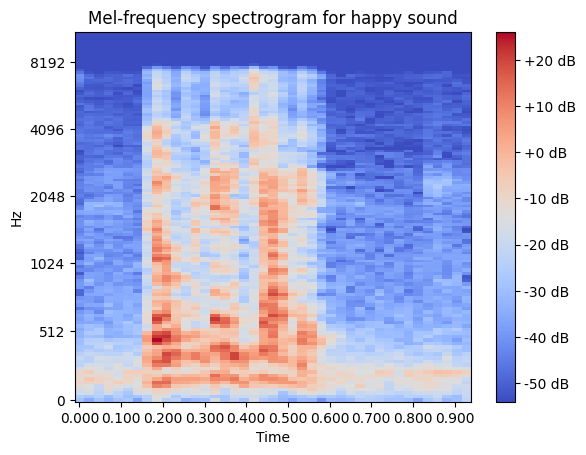

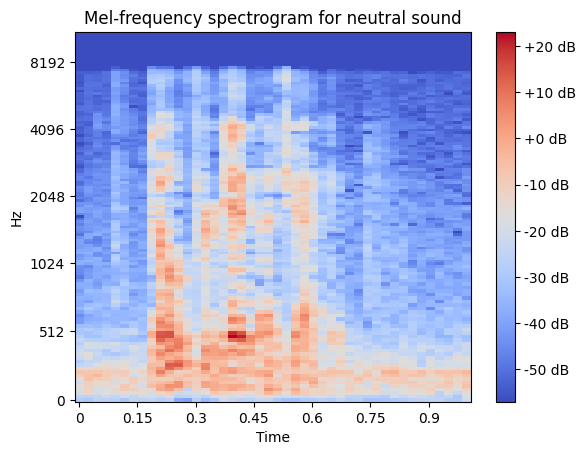

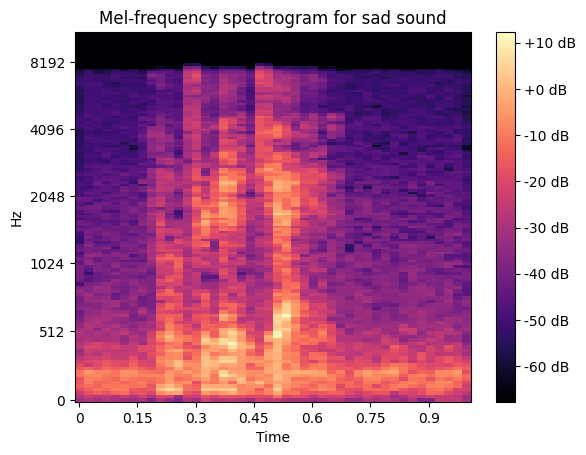

In [25]:
c=0
for idx,path in enumerate(guy1):
    emotion=guy1_df['Emotion'][idx]
    print(emotion)
    IPython.display.display(IPython.display.Audio(path))
    melspectogram_wave_plot(path,emotion)
    if c==5:
        break
    c+=1

angry


disgust


fear


happy


neutral


sad


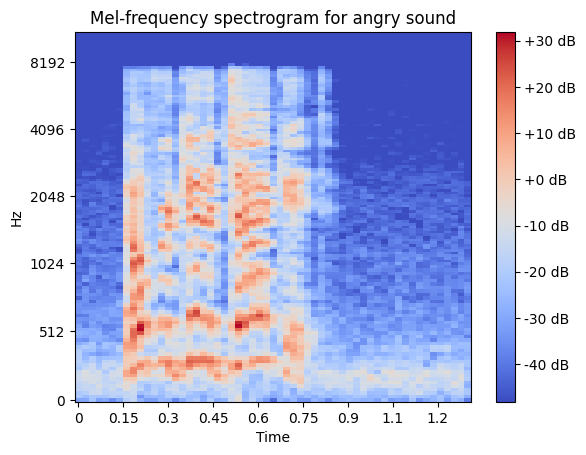

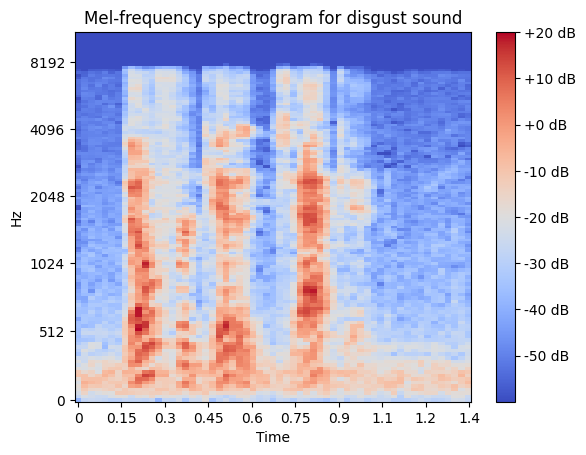

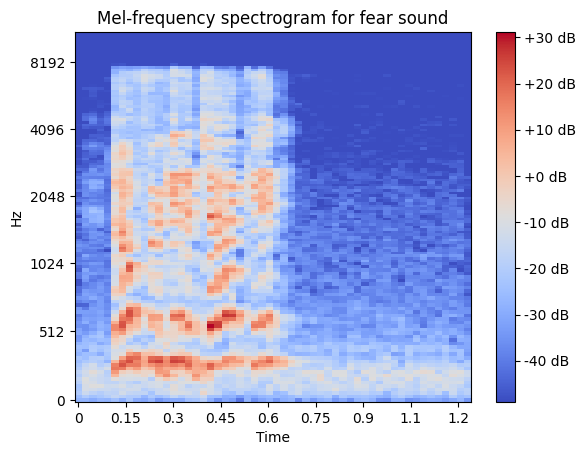

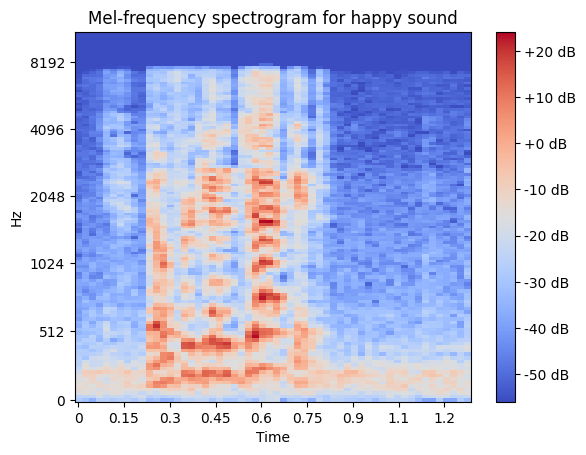

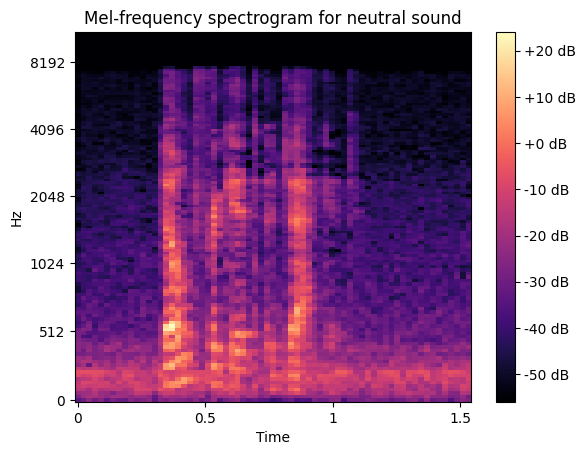

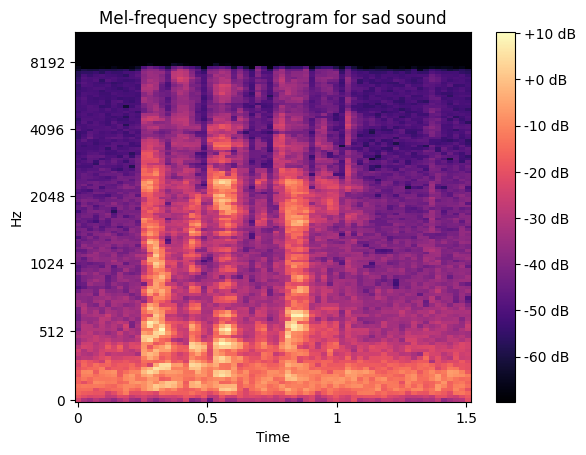

In [26]:
guy2_df=df[df['Person']=="1005"].reset_index()

guy2=np.array(guy2_df['File_Path'])
c=0
for idx,path in enumerate(guy2):
    emotion=guy2_df['Emotion'][idx]
    print(emotion)
    IPython.display.display(IPython.display.Audio(path))
    melspectogram_wave_plot(path,emotion)
    if c==5:
        break
    c+=1

In [24]:
df

Person  Emotion                                          File_Path  \
0      1001    angry  ../input/speech-emotion-recognition-en/Crema//...   
1      1001  disgust  ../input/speech-emotion-recognition-en/Crema//...   
2      1001     fear  ../input/speech-emotion-recognition-en/Crema//...   
3      1001    happy  ../input/speech-emotion-recognition-en/Crema//...   
4      1001  neutral  ../input/speech-emotion-recognition-en/Crema//...   
...     ...      ...                                                ...   
7437   1091  disgust  ../input/speech-emotion-recognition-en/Crema//...   
7438   1091     fear  ../input/speech-emotion-recognition-en/Crema//...   
7439   1091    happy  ../input/speech-emotion-recognition-en/Crema//...   
7440   1091  neutral  ../input/speech-emotion-recognition-en/Crema//...   
7441   1091      sad  ../input/speech-emotion-recognition-en/Crema//...   

     sentence intensity  Emotion_encoded  
0         DFA        XX                0  
1         DFA        XX                1  
2         DFA        XX                2  
3         DFA        XX                3  
4         DFA        XX                4  
...       ...       ...              ...  
7437      WSI        XX                1  
7438      WSI        XX                2  
7439      WSI        XX                3  
7440      WSI        XX                4  
7441      WSI        XX                5  

[7442 rows x 6 columns]

In [244]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
#     TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
#     Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])

def augment_audio(y,sr):
    # Load audio file using librosa
    augmented_samples = augment(samples=y, sample_rate=sr)  
    
    audio_player = augmented_samples
    return augmented_samples

In [180]:
!pip install torchaudio

In [181]:
X_train.File_Path

0       ../input/speech-emotion-recognition-en/Crema//...
1       ../input/speech-emotion-recognition-en/Crema//...
2       ../input/speech-emotion-recognition-en/Crema//...
3       ../input/speech-emotion-recognition-en/Crema//...
4       ../input/speech-emotion-recognition-en/Crema//...
                              ...                        
5204    ../input/speech-emotion-recognition-en/Crema//...
5205    ../input/speech-emotion-recognition-en/Crema//...
5206    ../input/speech-emotion-recognition-en/Crema//...
5207    ../input/speech-emotion-recognition-en/Crema//...
5208    ../input/speech-emotion-recognition-en/Crema//...
Name: File_Path, Length: 5209, dtype: object

In [75]:
import torchaudio
import torchaudio.transforms as transforms

S_dB_Total = []
# S_dB_noisy_total = []
# Emotions_list_agumented = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for idx, path in tqdm(enumerate(df.File_Path)):
    waveform, sample_rate = torchaudio.load(path)
    
#     waveform_noisy = augment_audio(np.array(waveform), sample_rate)
    # Convert to tensor
    waveform = torch.tensor(waveform).to(device)
#     waveform_noisy = torch.tensor(waveform_noisy).to(device)
#     print(waveform.shape)

    # Convert to mel spectrogram
    mel_transform = transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=2048,
        hop_length=512,
        n_mels=128
    ).to(device)
    
    S = mel_transform(waveform)
#     print(S.shape)
#     S_noisy = mel_transform(waveform_noisy)
#     print(S_noisy.shape)

    # Convert to dB
    power_to_db = transforms.AmplitudeToDB()
    S_dB = power_to_db(S)
#     S_dB_noisy = power_to_db(S_noisy)

    S_dB_Total.append(S_dB.squeeze())
#     S_dB_noisy_total.append(S_dB_noisy.squeeze())
#     Emotions_list_agumented.append(df.Emotion_encoded[idx])

0it [00:00, ?it/s]/tmp/ipykernel_32/4223618374.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  waveform = torch.tensor(waveform).to(device)
7442it [00:30, 244.10it/s]


In [76]:
sizes=[]
for x in S_dB_Total:
    sizes.append(x.shape[1])

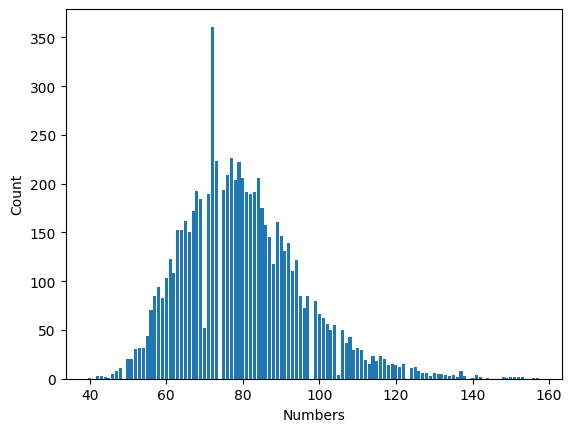

min is 40
max is 157


In [77]:
# Calculate the bin counts
bincount_array = np.histogram(sizes, bins=np.arange(min(sizes), max(sizes)+2))[0]

# Create a list of labels for the x-axis
x_labels = np.arange(min(sizes), max(sizes)+1)

# Plot the bin counts as a bar plot
plt.bar(x_labels, bincount_array)

# Set labels and title
plt.xlabel('Numbers')
plt.ylabel('Count')
plt.show()

print(f'min is {min(sizes)}')
print(f'max is {max(sizes)}')


In [103]:
padding_length = 160
padded_list = []
for array in S_dB_Total:
    current_shape = array.cpu().shape
    padding = [(0, 0), (0, padding_length - current_shape[1])]
    padded_array = np.pad(array.cpu(), padding, mode='constant', constant_values=0)
    padded_list.append(padded_array)

# Convert the padded list to a NumPy array
data_2D = np.array(padded_list)
    

In [105]:
data_2D.shape

(7442, 128, 160)

In [247]:
padding_length = 110
padded_list = []
for array in S_dB_noisy_total:
    current_shape = array.cpu().shape
    padding = [(0, 0), (0, padding_length - current_shape[1])]
    padded_array = np.pad(array.cpu(), padding, mode='constant', constant_values=0)
    padded_list.append(padded_array)

# Convert the padded list to a NumPy array
data_2D_Noisy = np.array(padded_list)
    

In [79]:
data_2D.shape

(7442, 128, 160)

In [249]:
data_2D[4]

array([[ -4.262927 ,  -6.780018 ,  -1.023214 , ...,   0.       ,
          0.       ,   0.       ],
       [ -2.2151365,  -3.408586 ,  -5.6257076, ...,   0.       ,
          0.       ,   0.       ],
       [ -5.4360347,  -1.0800917,  -6.423765 , ...,   0.       ,
          0.       ,   0.       ],
       ...,
       [-26.212658 , -25.119877 , -27.653763 , ...,   0.       ,
          0.       ,   0.       ],
       [-27.555845 , -25.932055 , -25.95644  , ...,   0.       ,
          0.       ,   0.       ],
       [-22.7018   , -25.985943 , -25.401676 , ...,   0.       ,
          0.       ,   0.       ]], dtype=float32)

In [250]:
data_2D_Noisy.shape

(5209, 128, 110)

In [251]:
data_2D_Noisy[4]

array([[ -4.262927 ,  -6.780018 ,  -1.023214 , ...,   0.       ,
          0.       ,   0.       ],
       [ -2.2151365,  -3.408586 ,  -5.6257076, ...,   0.       ,
          0.       ,   0.       ],
       [ -5.4360347,  -1.0800917,  -6.423765 , ...,   0.       ,
          0.       ,   0.       ],
       ...,
       [-26.212658 , -25.119877 , -27.653763 , ...,   0.       ,
          0.       ,   0.       ],
       [-27.555845 , -25.932055 , -25.95644  , ...,   0.       ,
          0.       ,   0.       ],
       [-22.7018   , -25.985943 , -25.401676 , ...,   0.       ,
          0.       ,   0.       ]], dtype=float32)

In [106]:
#normalization
from sklearn.preprocessing import MinMaxScaler

# Reshape the array to 2D
reshaped_data = data_2D.reshape((-1, 1))

# Initialize the MinMaxScaler
scaler1 = MinMaxScaler()

# Fit and transform the data
normalized_data = scaler1.fit_transform(reshaped_data)

# Reshape the normalized data back to the original shape
normalized_data = normalized_data.reshape(data_2D.shape)


In [253]:
# Reshape the array to 2D
reshaped_data = data_2D_Noisy.reshape((-1, 1))

# Initialize the MinMaxScaler
scaler2 = MinMaxScaler()

# Fit and transform the data
normalized_data_Noisy = scaler2.fit_transform(reshaped_data)

# Reshape the normalized data back to the original shape
normalized_data_Noisy = normalized_data_Noisy.reshape(data_2D_Noisy.shape)


In [14]:
normalized_data[1]

array([[0.5728386 , 0.5209585 , 0.4931724 , ..., 0.64767087, 0.64767087,
        0.64767087],
       [0.5479814 , 0.5444517 , 0.5370519 , ..., 0.64767087, 0.64767087,
        0.64767087],
       [0.5152755 , 0.59621143, 0.55543685, ..., 0.64767087, 0.64767087,
        0.64767087],
       ...,
       [0.47814873, 0.47154683, 0.4805687 , ..., 0.64767087, 0.64767087,
        0.64767087],
       [0.46865332, 0.45179135, 0.4756766 , ..., 0.64767087, 0.64767087,
        0.64767087],
       [0.45102102, 0.451133  , 0.47545537, ..., 0.64767087, 0.64767087,
        0.64767087]], dtype=float32)

In [255]:
normalized_data_Noisy[1]

array([[0.59236914, 0.6111256 , 0.63066936, ..., 0.648849  , 0.648849  ,
        0.648849  ],
       [0.654408  , 0.6127054 , 0.6135074 , ..., 0.648849  , 0.648849  ,
        0.648849  ],
       [0.67480344, 0.6280625 , 0.6285966 , ..., 0.648849  , 0.648849  ,
        0.648849  ],
       ...,
       [0.47514638, 0.47770178, 0.4771147 , ..., 0.648849  , 0.648849  ,
        0.648849  ],
       [0.4762863 , 0.48476985, 0.47585115, ..., 0.648849  , 0.648849  ,
        0.648849  ],
       [0.46955514, 0.47845042, 0.48169142, ..., 0.648849  , 0.648849  ,
        0.648849  ]], dtype=float32)

In [107]:
data=np.expand_dims(normalized_data, axis=1)

In [108]:
labels=df.Emotion_encoded.to_numpy()

In [18]:
labels.shape

(7442,)

In [16]:
data.shape

(7442, 1, 128, 110)

In [109]:
#train test split
from sklearn.model_selection import train_test_split
# Perform the train-test split (70% train, 30% test & validation)
X_train, X_testAndVal, y_train, y_testAndVal = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)

# Perform the train-validation split (50% test, 50% validation) (15%)
X_val, X_test, y_val, y_test = train_test_split(X_testAndVal, y_testAndVal, test_size=0.5, stratify=y_testAndVal, random_state=42)

# Print the sizes of each split
print("Train set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))



Train set size: 5209
Validation set size: 1116
Test set size: 1117


In [257]:
y_train=y_train.to_numpy()

In [258]:
X_train.shape

(5209, 1, 128, 110)

In [259]:
noisy_data=np.expand_dims(normalized_data_Noisy, axis=1)

In [260]:
noisy_data.shape

(5209, 1, 128, 110)

In [261]:
labels_noisy=np.array(Emotions_list_agumented)

In [262]:
labels_noisy.shape

(5209,)

In [263]:
X_train.shape

(5209, 1, 128, 110)

In [264]:
noisy_portion=noisy_data
noisy_portion_labels=labels_noisy

In [265]:
noisy_portion.shape

(5209, 1, 128, 110)

In [266]:
noisy_portion_labels.shape

(5209,)

In [267]:
X_train.shape

(5209, 1, 128, 110)

In [268]:
noisy_portion.shape

(5209, 1, 128, 110)

In [269]:
#add augmented audios
X_train_new=np.vstack((X_train, noisy_portion))


In [270]:
X_train_new.shape

(10418, 1, 128, 110)

In [271]:
y_train.shape

(5209, 1)

In [272]:
noisy_portion_labels.shape

(5209,)

In [273]:
y_train_new=np.concatenate((y_train.squeeze(), noisy_portion_labels))


In [274]:
y_train_new.shape

(10418,)

In [275]:
# Shuffle the indices
shuffled_indices = np.random.permutation(len(X_train_new))

# Use the shuffled indices to shuffle both arrays
X_train_new = X_train_new[shuffled_indices]
y_train_new = y_train_new[shuffled_indices]

In [276]:
S_dB_Total = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for idx, path in tqdm(enumerate(X_test.File_Path)):
    waveform, sample_rate = torchaudio.load(path)
    

    # Convert to tensor
    waveform = torch.tensor(waveform).to(device)


    # Convert to mel spectrogram
    mel_transform = transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=2048,
        hop_length=1024,
        n_mels=128
    ).to(device)
    
    S = mel_transform(waveform)

    # Convert to dB
    power_to_db = transforms.AmplitudeToDB()
    S_dB = power_to_db(S)

    S_dB_Total.append(S_dB.squeeze())

0it [00:00, ?it/s]/tmp/ipykernel_31/3379929270.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  waveform = torch.tensor(waveform).to(device)
1117it [00:04, 242.62it/s]


In [277]:
padding_length = 110
padded_list = []
for array in S_dB_Total:
    current_shape = array.cpu().shape
    padding = [(0, 0), (0, padding_length - current_shape[1])]
    padded_array = np.pad(array.cpu(), padding, mode='constant', constant_values=0)
    padded_list.append(padded_array)

# Convert the padded list to a NumPy array
test_2D = np.array(padded_list)

In [278]:
# Reshape the array to 2D
reshaped_data = test_2D.reshape((-1, 1))

# Initialize the MinMaxScaler
scaler1 = MinMaxScaler()

# Fit and transform the data
normalized_data = scaler1.fit_transform(reshaped_data)

# Reshape the normalized data back to the original shape
normalized_data = normalized_data.reshape(test_2D.shape)

In [279]:
X_test=np.expand_dims(normalized_data, axis=1)
y_test=y_test.to_numpy().squeeze()

In [280]:
S_dB_Total = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for idx, path in tqdm(enumerate(X_val.File_Path)):
    waveform, sample_rate = torchaudio.load(path)
    

    # Convert to tensor
    waveform = torch.tensor(waveform).to(device)


    # Convert to mel spectrogram
    mel_transform = transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=2048,
        hop_length=1024,
        n_mels=128
    ).to(device)
    
    S = mel_transform(waveform)

    # Convert to dB
    power_to_db = transforms.AmplitudeToDB()
    S_dB = power_to_db(S)

    S_dB_Total.append(S_dB.squeeze())


0it [00:00, ?it/s]/tmp/ipykernel_31/1376523593.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  waveform = torch.tensor(waveform).to(device)
1116it [00:04, 240.11it/s]


In [281]:
padding_length = 110
padded_list = []
for array in S_dB_Total:
    current_shape = array.cpu().shape
    padding = [(0, 0), (0, padding_length - current_shape[1])]
    padded_array = np.pad(array.cpu(), padding, mode='constant', constant_values=0)
    padded_list.append(padded_array)

# Convert the padded list to a NumPy array
val_2D = np.array(padded_list)


In [282]:
# Reshape the array to 2D
reshaped_data = val_2D.reshape((-1, 1))

# Initialize the MinMaxScaler
scaler1 = MinMaxScaler()

# Fit and transform the data
normalized_data = scaler1.fit_transform(reshaped_data)

# Reshape the normalized data back to the original shape
normalized_data = normalized_data.reshape(val_2D.shape)


In [283]:
X_val=np.expand_dims(normalized_data, axis=1)
y_val=y_val.to_numpy().squeeze()

In [110]:
from torch.utils.data import Dataset, DataLoader

class AudioDataset(Dataset):
    def __init__(self,audio,label):
        self.audios=audio
        self.labels=label

    def __len__(self):
        return len(self.audios)

    def get_batch_imgs(self, idx):
        # Fetch a batch of inputs
        return self.audios[idx]
    
    def get_batch_labels(self, idx):
    # Fetch a batch of inputs
        return self.labels[idx]

    
    def __getitem__(self, index):
        audios=self.get_batch_imgs(index)
        labels=self.get_batch_labels(index)
        return audios,labels


In [111]:
X_train.shape

(5209, 1, 128, 160)

In [112]:
train_dataset = AudioDataset(X_train,y_train)
val_dataset = AudioDataset(X_val, y_val)
test_dataset = AudioDataset(X_test, y_test)

# Create a DataLoader from the dataset

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader=DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader=DataLoader(test_dataset, batch_size=64, shuffle=False)


# Architecture

In [46]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
#         self.network = nn.Sequential(
#             nn.Conv2d(1, 512, kernel_size=5, stride=1), #input shape is (128, 110,1) o/p ->(124,106,512)
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=5, stride=2), # i/p:(124,106,512) o/p-> (60,51,512)
#             nn.Conv2d(512, 512, kernel_size=5, stride=1), #input shape is (60,51,512) o/p ->(56,47,512)
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=5, stride=2), # i/p:(56,47,512) o/p-> (26,22,512)
#             nn.Conv2d(512, 128, kernel_size=5, stride=1), #input shape is (26,22,512) o/p ->(22,18,128)
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=5, stride=2), # i/p:(22,18,128) o/p-> (9,7,128)
#             nn.Flatten(), # i/p:(9,7,128) o/p-> (9*7*128,)
#             nn.Linear(9*7*128, 265),
#             nn.ReLU(),
#             nn.Linear(265,6),
#             nn.Softmax()
#         )
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1
                                   ,out_channels=16,
                                   kernel_size=3,
                                   stride=1,
                                   padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
        )#input shape is (128, 110,1) o/p ->(65,56,16)
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=16
                               ,out_channels=32,
                               kernel_size=3,
                               stride=1,
                               padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2)
    )#input shape is (65,56,16) o/p ->(33,29,32)
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=32
                           ,out_channels=64,
                           kernel_size=3,
                           stride=1,
                           padding=2),
nn.ReLU(),
nn.MaxPool2d(kernel_size=2)
)#input shape is (33,29,32) o/p ->(17,15,64)
        
        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=64
                           ,out_channels=128,
                           kernel_size=3,
                           stride=1,
                           padding=2),
nn.ReLU(),
nn.MaxPool2d(kernel_size=2)
)#input shape is (17,15,64) o/p ->(9,8,128)

        self.flatten=nn.Flatten()
        self.linear=nn.Linear(9 * 8 * 128 , 6)
        self.softmax=nn.Softmax(dim=1)
    

        
    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.flatten(x)
        logits = self.linear(x)
        predictions=self.softmax(logits)
        return predictions

In [113]:
#change nn.sequential to take dict to make more readable 

class parallel_all_you_want(nn.Module):
    # Define all layers present in the network
    def __init__(self,num_emotions):
        super().__init__() 
        
        ################ TRANSFORMER BLOCK #############################
        # maxpool the input feature map/tensor to the transformer 
        # a rectangular kernel worked better here for the rectangular input spectrogram feature map/tensor
        self.transformer_maxpool = nn.MaxPool2d(kernel_size=[1,4], stride=[1,4])
        
        # define single transformer encoder layer
        # self-attention + feedforward network from "Attention is All You Need" paper
        # 4 multi-head self-attention layers each with 128-->512--->128 feedforward network
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=128, # input feature (frequency) dim after maxpooling 128*110 -> 128*27 (Melspectorgram*time)
            nhead=4, # 4 self-attention layers in each multi-head self-attention layer in each encoder block
            dim_feedforward=512, # 2 linear layers in each encoder block's feedforward network: dim 128-->512--->128
            dropout=0.4, 
            activation='relu' # ReLU: avoid saturation/tame gradient/reduce compute time
        )
        
        # I'm using 4 instead of the 6 identical stacked encoder layrs used in Attention is All You Need paper
        # Complete transformer block contains 4 full transformer encoder layers (each w/ multihead self-attention+feedforward)
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=4)
        
        ############### 1ST PARALLEL 2D CONVOLUTION BLOCK ############
        # 3 sequential conv2D layers: (1,128,110) --> (16,64,55) -> (32,15,13) -> (64,4,3)
        self.conv2Dblock1 = nn.Sequential(
            
            # 1st 2D convolution layer
            nn.Conv2d(
                in_channels=1, # input volume depth == input channel dim == 1
                out_channels=16, # expand output feature map volume's depth to 16
                kernel_size=3, # typical 3*3 stride 1 kernel
                stride=1,
                padding=1
                      ),  #(1,128,160) - > (16,128,160)
            nn.BatchNorm2d(16), # batch normalize the output feature map before activation
            nn.ReLU(), # feature map --> activation map
            nn.MaxPool2d(kernel_size=2, stride=2), #typical maxpool kernel size  #(16,128,160) - > (16,64,80)
            nn.Dropout(p=0.3), #randomly zero 30% of 1st layer's output feature map in training
            
            # 2nd 2D convolution layer identical to last except output dim, maxpool kernel
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, # expand output feature map volume's depth to 32
                kernel_size=3,
                stride=1,
                padding=1
                      ),#(16,64,80) - > (32,64,80)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), # increase maxpool kernel for subsequent filters #(32,64,80) - > (32,16,20)
            nn.Dropout(p=0.3), 
            
            # 3rd 2D convolution layer identical to last except output dim
            nn.Conv2d(
                in_channels=32,
                out_channels=64, # expand output feature map volume's depth to 64
                kernel_size=3,
                stride=1,
                padding=1
                      ),#(32,16,20) - > (64,16,20)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),#(64,16,20) - > (64,4,5)
            nn.Dropout(p=0.3),
        )
        ############### 2ND PARALLEL 2D CONVOLUTION BLOCK ############
        # 3 sequential conv2D layers: (1,128,110) --> (16,64,55) -> (32,15,13) -> (64,4,3)
        self.conv2Dblock2 = nn.Sequential(
            # 1st 2D convolution layer
            nn.Conv2d(
                in_channels=1, # input volume depth == input channel dim == 1
                out_channels=16, # expand output feature map volume's depth to 16
                kernel_size=3, # typical 3*3 stride 1 kernel
                stride=1,
                padding=1
                      ),#(1,128,110) - > (16,128,110)
            nn.BatchNorm2d(16), # batch normalize the output feature map before activation
            nn.ReLU(), # feature map --> activation map
            nn.MaxPool2d(kernel_size=2, stride=2), #typical maxpool kernel size (16,128,110) - > (16,64,55)
            nn.Dropout(p=0.3), #randomly zero 30% of 1st layer's output feature map in training
            
            # 2nd 2D convolution layer identical to last except output dim, maxpool kernel
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, # expand output feature map volume's depth to 32
                kernel_size=3,
                stride=1,
                padding=1
                      ),#(16,64,55) - > (32,64,55)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), # increase maxpool kernel for subsequent filters (32,64,55) - > (32,15,13)
            nn.Dropout(p=0.3), 
            
            # 3rd 2D convolution layer identical to last except output dim
            nn.Conv2d(
                in_channels=32,
                out_channels=64, # expand output feature map volume's depth to 64
                kernel_size=3,
                stride=1,
                padding=1
                      ),#(32,64,55) - > (64,15,13)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),#(64,15,13) - > (64,4,3)
            nn.Dropout(p=0.3),
        )

        ################# FINAL LINEAR BLOCK ####################
        # Linear softmax layer to take final concatenated embedding tensor 
        #    from parallel 2D convolutional and transformer blocks, output 6 logits 
        # Each full convolution block outputs (64*4*3) embedding flattened to dim 576 1D array 
        
        
        # Full transformer block outputs 128*27 feature map, which we time-avg to dim 128 1D array
        # 576*2+128 == 1280 input features --> 6 output emotions 
        self.fc1_linear = nn.Linear(1280*2+128,num_emotions) 
        
        ### Softmax layer for the 6 output logits from final FC linear layer 
        self.softmax_out = nn.Softmax(dim=1) # dim==1 is the freq embedding
        
    # define one complete parallel fwd pass of input feature tensor thru 2*conv+1*transformer blocks
    def forward(self,x):
        
        ############ 1st parallel Conv2D block: 4 Convolutional layers ############################
        # create final feature embedding from 1st convolutional layer 
        # input features pased through 4 sequential 2D convolutional layers
        conv2d_embedding1 = self.conv2Dblock1(x) # x == N/batch * channel * freq * time
        
        
#         print(f'conv2d_embedding1 (64,3,3)= {conv2d_embedding1.shape}')

        # flatten final 64*1*8 feature map from convolutional layers to length 512 1D array 
        # skip the 1st (N/batch) dimension when flattening
        conv2d_embedding1 = torch.flatten(conv2d_embedding1, start_dim=1) 
#         print(f'conv2d_embedding1 After flatten= {conv2d_embedding1.shape}')

        ############ 2nd parallel Conv2D block: 4 Convolutional layers #############################
        # create final feature embedding from 2nd convolutional layer 
        # input features pased through 4 sequential 2D convolutional layers
        conv2d_embedding2 = self.conv2Dblock2(x) # x == N/batch * channel * freq * time

#         print(f'conv2d_embedding2 (64,3,3) = {conv2d_embedding2.shape}')

        # flatten final 64*1*8 feature map from convolutional layers to length 512 1D array 
        # skip the 1st (N/batch) dimension when flattening.
        conv2d_embedding2 = torch.flatten(conv2d_embedding2, start_dim=1) 
#         print(f'conv2d_embedding2 after flatten = {conv2d_embedding2.shape}')

         
        ########## 4-encoder-layer Transformer block w/ 128-->512-->128 feedfwd network ##############
        # maxpool input feature map: 1*40*282 w/ 1*4 kernel --> 1*128*27
        x_maxpool = self.transformer_maxpool(x)
#         print(f'transformer max pool output = {x_maxpool.shape}')

        # remove channel dim: 1*128*27 --> 128*27 
        x_maxpool_reduced = torch.squeeze(x_maxpool,1)
#         print(f'transformer max pool output after squeeze = {x_maxpool_reduced.shape}')

#         torch.Size([64, 128, 27])
        # convert maxpooled feature map format: batch * freq * time ---> time * batch * freq format
        # because transformer encoder layer requires tensor in format: time * batch * embedding (freq)
        x = x_maxpool_reduced.permute(2,0,1) 
        
        # finally, pass reduced input feature map x into transformer encoder layers
        transformer_output = self.transformer_encoder(x)
#         print(f'transformer_output= {transformer_output.shape}')
        # create final feature emedding from transformer layer by taking mean in the time dimension (now the 0th dim)
        # transformer outputs 2x128 (melSpectogram embedding*time) feature map, take mean of columns i.e. take time average
        transformer_embedding = torch.mean(transformer_output, dim=0) # dim 128x27 --> 128
#         print(f'transformer embedding= {transformer_output.shape}')


        ############# concatenate freq embeddings from convolutional and transformer blocks ######
        # concatenate embedding tensors output by parallel 2*conv and 1*transformer blocks
#         print("Concatination")
#         print(f'conv2d_embedding1= {conv2d_embedding1.shape}')
#         print(f'conv2d_embedding1= {conv2d_embedding2.shape}')
#         print(f'transformer_embedding= {transformer_embedding.shape}')

        complete_embedding = torch.cat([conv2d_embedding1, conv2d_embedding2,transformer_embedding], dim=1) 
#         print(f'complete_embedding= {complete_embedding.shape}')

        
        ######### final FC linear layer, need logits for loss #########################
        output_logits = self.fc1_linear(complete_embedding)  
        
#         print(f'output_logits= {output_logits.shape}')

        ######### Final Softmax layer: use logits from FC linear, get softmax for prediction ######
        output_softmax = self.softmax_out(output_logits)
#         print(f'output_softmax= {output_softmax.shape}')

        # need output logits to compute cross entropy loss, need softmax probabilities to predict class
        return output_logits, output_softmax                       


In [114]:
from torchinfo import summary

# need device to instantiate model
device = 'cuda'

# instantiate model for 8 emotions and move to GPU 
model = parallel_all_you_want(6).to(device)

# include input feature map dims in call to summary()
summary(model, input_size=(32, 1, 128, 160))


/opt/conda/lib/python3.10/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/opt/conda/lib/python3.10/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                        Output Shape              Param #
parallel_all_you_want                         [32, 6]                   --
├─Sequential: 1-1                             [32, 64, 4, 5]            --
│    └─Conv2d: 2-1                            [32, 16, 128, 160]        160
│    └─BatchNorm2d: 2-2                       [32, 16, 128, 160]        32
│    └─ReLU: 2-3                              [32, 16, 128, 160]        --
│    └─MaxPool2d: 2-4                         [32, 16, 64, 80]          --
│    └─Dropout: 2-5                           [32, 16, 64, 80]          --
│    └─Conv2d: 2-6                            [32, 32, 64, 80]          4,640
│    └─BatchNorm2d: 2-7                       [32, 32, 64, 80]          64
│    └─ReLU: 2-8                              [32, 32, 64, 80]          --
│    └─MaxPool2d: 2-9                         [32, 32, 16, 20]          --
│    └─Dropout: 2-10                          [32, 32, 16, 20]          --
│    └─Conv2d: 2

In [135]:
import torch.optim as optim

EPOCHS=500
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn =nn.CrossEntropyLoss().to(DEVICE)

LEARNING_RATE=1e-4

model = parallel_all_you_want(6).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=LEARNING_RATE, momentum=0.8)


In [227]:
# from torchsummary import summary

# # need device to instantiate model
# device = 'cuda'

# # instantiate model for 8 emotions and move to GPU 
# model = parallel_all_you_want(6).to(device)

# # include input feature map dims in call to summary()
# summary(model, input_size=(1,128,110))


In [136]:
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model = model.train()

    losses = []
    correct_predictions = 0
    total_predictions = 0

    for train_input, train_label in tqdm(data_loader):
        train_label = train_label.to(device)
        train_input = train_input.to(device)

        optimizer.zero_grad()
        
        output_logits, output_softmax = model(train_input.float())
        predictions = torch.argmax(output_softmax,dim=1)
        total_predictions += train_label.size(0)
        
        correct_predictions += (predictions == train_label).sum().item()
        
        loss = loss_fn(output_logits, train_label)

        losses.append(loss.item())


        loss.backward()
        optimizer.step()

    accuracy = correct_predictions / total_predictions
    mean_loss = np.mean(losses)

    return mean_loss, accuracy


In [137]:
def eval_model(model, data_loader, loss_fn, device):
    model = model.eval()

    losses = []
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():            
        for val_input, val_label in data_loader:
            val_label = val_label.to(device)
            val_input = val_input.to(device)

            optimizer.zero_grad()

            output_logits, output_softmax = model(val_input.float())

            predictions = torch.argmax(output_softmax,dim=1)
            total_predictions += val_label.size(0)

            correct_predictions += (predictions == val_label).sum().item()

            loss = loss_fn(output_logits, val_label)

            losses.append(loss.item())


        accuracy = correct_predictions / total_predictions
        mean_loss = np.mean(losses)

    return mean_loss, accuracy

In [138]:
from collections import defaultdict
history = defaultdict(list)


In [ ]:
import math
loss=math.inf
for epoch in range(EPOCHS):


    train_loss,train_acc = train_epoch(model,train_dataloader,loss_fn, optimizer, DEVICE)
    
    val_loss,val_acc = eval_model(model,val_dataloader,loss_fn, DEVICE)
    
    
#     if epoch%5 == 0 :
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    print(f'Train loss {train_loss}')
    print(f'Train Accuracy {train_acc}')

    print(f'Val   loss {val_loss}')
    print(f'Val   Acc {val_acc}')

    print()
        
    if val_loss < loss:
        torch.save(model.state_dict(), 'best_model_state.bin')
        loss = val_loss

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)


100%|██████████| 82/82 [00:03<00:00, 20.89it/s]


Epoch 1/500
----------
Train loss 1.855121903303193
Train Accuracy 0.23939335765022077
Val   loss 1.7238917218314276
Val   Acc 0.25



100%|██████████| 82/82 [00:03<00:00, 21.00it/s]


Epoch 2/500
----------
Train loss 1.6410198138981331
Train Accuracy 0.3250143981570359
Val   loss 1.715280466609531
Val   Acc 0.3100358422939068



100%|██████████| 82/82 [00:03<00:00, 20.71it/s]


Epoch 3/500
----------
Train loss 1.582963674533658
Train Accuracy 0.3528508350931081
Val   loss 1.6843050784534879
Val   Acc 0.30913978494623656



100%|██████████| 82/82 [00:03<00:00, 21.01it/s]


Epoch 4/500
----------
Train loss 1.5622318241654374
Train Accuracy 0.37070454981762335
Val   loss 1.6392381522390578
Val   Acc 0.29838709677419356



100%|██████████| 82/82 [00:03<00:00, 20.89it/s]


Epoch 5/500
----------
Train loss 1.523191610487496
Train Accuracy 0.38433480514494145
Val   loss 1.597369114557902
Val   Acc 0.3387096774193548



100%|██████████| 82/82 [00:03<00:00, 20.97it/s]


Epoch 6/500
----------
Train loss 1.5154449082002408
Train Accuracy 0.3899020925321559
Val   loss 1.6601115862528484
Val   Acc 0.32974910394265233



100%|██████████| 82/82 [00:03<00:00, 21.01it/s]


Epoch 7/500
----------
Train loss 1.500127548124732
Train Accuracy 0.39047801881359184
Val   loss 1.6116557783550687
Val   Acc 0.3449820788530466



100%|██████████| 82/82 [00:03<00:00, 20.92it/s]


Epoch 8/500
----------
Train loss 1.4842881516712467
Train Accuracy 0.4000767901708581
Val   loss 1.6433668666415744
Val   Acc 0.3270609318996416



100%|██████████| 82/82 [00:03<00:00, 21.03it/s]


Epoch 9/500
----------
Train loss 1.470597768702158
Train Accuracy 0.40871568439239775
Val   loss 1.5965922673543294
Val   Acc 0.3333333333333333



100%|██████████| 82/82 [00:03<00:00, 20.85it/s]


Epoch 10/500
----------
Train loss 1.4524786370556528
Train Accuracy 0.4089076598195431
Val   loss 1.622801211145189
Val   Acc 0.32616487455197135



100%|██████████| 82/82 [00:03<00:00, 20.95it/s]


Epoch 11/500
----------
Train loss 1.4355658656213341
Train Accuracy 0.42196198886542524
Val   loss 1.6211278173658583
Val   Acc 0.31362007168458783



100%|██████████| 82/82 [00:03<00:00, 21.03it/s]


Epoch 12/500
----------
Train loss 1.4236703893033469
Train Accuracy 0.4296410059512382
Val   loss 1.5703629785113864
Val   Acc 0.3575268817204301



100%|██████████| 82/82 [00:03<00:00, 20.84it/s]


Epoch 13/500
----------
Train loss 1.4122131641318159
Train Accuracy 0.4244576694183145
Val   loss 1.539563324716356
Val   Acc 0.3682795698924731



100%|██████████| 82/82 [00:03<00:00, 21.03it/s]


Epoch 14/500
----------
Train loss 1.4178656426871694
Train Accuracy 0.42541754655404107
Val   loss 1.5500393443637424
Val   Acc 0.3449820788530466



100%|██████████| 82/82 [00:03<00:00, 21.03it/s]


Epoch 15/500
----------
Train loss 1.3972830103664864
Train Accuracy 0.43424841620272603
Val   loss 1.5588006642129686
Val   Acc 0.34139784946236557



100%|██████████| 82/82 [00:03<00:00, 20.70it/s]


Epoch 16/500
----------
Train loss 1.3863240393196665
Train Accuracy 0.43885582645421384
Val   loss 1.6470898456043668
Val   Acc 0.29838709677419356



100%|██████████| 82/82 [00:03<00:00, 21.01it/s]


Epoch 17/500
----------
Train loss 1.3640109344226559
Train Accuracy 0.45095027836436935
Val   loss 1.7158743805355496
Val   Acc 0.27419354838709675



100%|██████████| 82/82 [00:03<00:00, 20.77it/s]


Epoch 18/500
----------
Train loss 1.3531630170054552
Train Accuracy 0.45440583605298523
Val   loss 1.6755391955375671
Val   Acc 0.30197132616487454



100%|██████████| 82/82 [00:03<00:00, 20.90it/s]


Epoch 19/500
----------
Train loss 1.3523861983927286
Train Accuracy 0.45901324630447304
Val   loss 1.622366143597497
Val   Acc 0.2948028673835125



100%|██████████| 82/82 [00:03<00:00, 21.02it/s]


Epoch 20/500
----------
Train loss 1.3546971344366305
Train Accuracy 0.450758302937224
Val   loss 1.7254430651664734
Val   Acc 0.2840501792114695



100%|██████████| 82/82 [00:03<00:00, 20.94it/s]


Epoch 21/500
----------
Train loss 1.341669079734058
Train Accuracy 0.4580533691687464
Val   loss 1.6979194084803264
Val   Acc 0.28763440860215056



100%|██████████| 82/82 [00:03<00:00, 21.02it/s]


Epoch 22/500
----------
Train loss 1.3360806616341196
Train Accuracy 0.46227682856594354
Val   loss 1.813404791884952
Val   Acc 0.27419354838709675



100%|██████████| 82/82 [00:03<00:00, 21.03it/s]


Epoch 23/500
----------
Train loss 1.3341868970452286
Train Accuracy 0.46016509886734497
Val   loss 1.8091183371014066
Val   Acc 0.2840501792114695



100%|██████████| 82/82 [00:03<00:00, 20.98it/s]


Epoch 24/500
----------
Train loss 1.3176394293947917
Train Accuracy 0.4688039930888846
Val   loss 1.7526310218705072
Val   Acc 0.3046594982078853



100%|██████████| 82/82 [00:03<00:00, 21.02it/s]


Epoch 25/500
----------
Train loss 1.3178879167975448
Train Accuracy 0.4711076982146285
Val   loss 1.730581329928504
Val   Acc 0.28584229390681004



100%|██████████| 82/82 [00:03<00:00, 20.81it/s]


Epoch 26/500
----------
Train loss 1.3061163425445557
Train Accuracy 0.4853138798233826
Val   loss 1.5567490193578932
Val   Acc 0.3602150537634409



100%|██████████| 82/82 [00:03<00:00, 20.92it/s]


Epoch 27/500
----------
Train loss 1.2966844744798613
Train Accuracy 0.4791706661547322
Val   loss 1.5963962409231398
Val   Acc 0.36200716845878134



100%|██████████| 82/82 [00:03<00:00, 20.98it/s]


Epoch 28/500
----------
Train loss 1.2854650093287956
Train Accuracy 0.4878095603762718
Val   loss 1.4636384579870436
Val   Acc 0.41308243727598565



100%|██████████| 82/82 [00:03<00:00, 20.94it/s]


Epoch 29/500
----------
Train loss 1.28026805709048
Train Accuracy 0.4866577078133999
Val   loss 1.6448875334527757
Val   Acc 0.34050179211469533



100%|██████████| 82/82 [00:03<00:00, 21.03it/s]


Epoch 30/500
----------
Train loss 1.2629124682124069
Train Accuracy 0.4995200614321367
Val   loss 1.4809107648001776
Val   Acc 0.40949820788530467



100%|██████████| 82/82 [00:03<00:00, 21.03it/s]


Epoch 31/500
----------
Train loss 1.2527687535053347
Train Accuracy 0.4941447494720676
Val   loss 1.4522135588857863
Val   Acc 0.40232974910394265



100%|██████████| 82/82 [00:03<00:00, 20.91it/s]


Epoch 32/500
----------
Train loss 1.245732151880497
Train Accuracy 0.5037435208293338
Val   loss 1.5708899233076308
Val   Acc 0.3718637992831541



100%|██████████| 82/82 [00:03<00:00, 20.70it/s]


Epoch 33/500
----------
Train loss 1.2403988002277002
Train Accuracy 0.5119984641965828
Val   loss 1.4314109815491571
Val   Acc 0.4211469534050179



100%|██████████| 82/82 [00:03<00:00, 21.03it/s]


Epoch 34/500
----------
Train loss 1.2359330116248712
Train Accuracy 0.5173737761566519
Val   loss 1.4121283955044217
Val   Acc 0.43010752688172044



100%|██████████| 82/82 [00:03<00:00, 20.94it/s]


Epoch 35/500
----------
Train loss 1.2083882238806747
Train Accuracy 0.5206373584181225
Val   loss 1.3986747860908508
Val   Acc 0.43189964157706096



100%|██████████| 82/82 [00:03<00:00, 21.03it/s]


Epoch 36/500
----------
Train loss 1.1976884872448155
Train Accuracy 0.525052793242465
Val   loss 1.321223537127177
Val   Acc 0.460573476702509



100%|██████████| 82/82 [00:03<00:00, 20.84it/s]


Epoch 37/500
----------
Train loss 1.1815456275532885
Train Accuracy 0.531579957765406
Val   loss 1.391798045900133
Val   Acc 0.45161290322580644



100%|██████████| 82/82 [00:03<00:00, 21.03it/s]


Epoch 38/500
----------
Train loss 1.1775189725364126
Train Accuracy 0.5302361297753887
Val   loss 1.3504316409428914
Val   Acc 0.46774193548387094



100%|██████████| 82/82 [00:03<00:00, 20.98it/s]


Epoch 39/500
----------
Train loss 1.1636701502451083
Train Accuracy 0.5454021885198694
Val   loss 1.2744024991989136
Val   Acc 0.5



100%|██████████| 82/82 [00:03<00:00, 20.88it/s]


Epoch 40/500
----------
Train loss 1.144460916519165
Train Accuracy 0.5536571318871184
Val   loss 1.268973449865977
Val   Acc 0.492831541218638



100%|██████████| 82/82 [00:03<00:00, 20.82it/s]


Epoch 41/500
----------
Train loss 1.1385577771721818
Train Accuracy 0.557496640430025
Val   loss 1.3657343188921611
Val   Acc 0.45698924731182794



100%|██████████| 82/82 [00:03<00:00, 20.99it/s]


Epoch 42/500
----------
Train loss 1.1153972236121572
Train Accuracy 0.56344787867153
Val   loss 1.2185276713636186
Val   Acc 0.517921146953405



100%|██████████| 82/82 [00:03<00:00, 20.93it/s]


Epoch 43/500
----------
Train loss 1.108464877053005
Train Accuracy 0.5674793626415818
Val   loss 1.2439572678671942
Val   Acc 0.5062724014336918



100%|██████████| 82/82 [00:03<00:00, 21.01it/s]


Epoch 44/500
----------
Train loss 1.0799200389443375
Train Accuracy 0.5797657899788827
Val   loss 1.221027433872223
Val   Acc 0.521505376344086



100%|██████████| 82/82 [00:03<00:00, 20.83it/s]


Epoch 45/500
----------
Train loss 1.0924209232737379
Train Accuracy 0.5736225763102323
Val   loss 1.2110640274153814
Val   Acc 0.543010752688172



100%|██████████| 82/82 [00:03<00:00, 21.01it/s]


Epoch 46/500
----------
Train loss 1.0645796140519583
Train Accuracy 0.5837972739489345
Val   loss 1.2825150622261896
Val   Acc 0.5241935483870968



100%|██████████| 82/82 [00:03<00:00, 21.00it/s]


Epoch 47/500
----------
Train loss 1.0440536577527115
Train Accuracy 0.5974275292762526
Val   loss 1.2627414729860094
Val   Acc 0.5053763440860215



100%|██████████| 82/82 [00:03<00:00, 20.83it/s]


Epoch 48/500
----------
Train loss 1.0583085490436088
Train Accuracy 0.5834133230946439
Val   loss 1.2435589366488986
Val   Acc 0.532258064516129



100%|██████████| 82/82 [00:03<00:00, 20.88it/s]


Epoch 49/500
----------
Train loss 1.027523630275959
Train Accuracy 0.6058744480706469
Val   loss 1.3792567584249709
Val   Acc 0.49014336917562723



100%|██████████| 82/82 [00:03<00:00, 21.01it/s]


Epoch 50/500
----------
Train loss 1.0302239336618564
Train Accuracy 0.6022269149548858
Val   loss 1.2561678753958807
Val   Acc 0.5286738351254481



100%|██████████| 82/82 [00:03<00:00, 20.88it/s]


Epoch 51/500
----------
Train loss 1.011731694384319
Train Accuracy 0.6041466692263391
Val   loss 1.356373303466373
Val   Acc 0.49910394265232977



100%|██████████| 82/82 [00:03<00:00, 21.01it/s]


Epoch 52/500
----------
Train loss 0.9951441019046597
Train Accuracy 0.612401612593588
Val   loss 1.197688576247957
Val   Acc 0.5448028673835126



100%|██████████| 82/82 [00:03<00:00, 20.94it/s]


Epoch 53/500
----------
Train loss 0.9953674179751698
Train Accuracy 0.6168170474179305
Val   loss 1.2443281014760335
Val   Acc 0.5304659498207885



100%|██████████| 82/82 [00:03<00:00, 21.00it/s]


Epoch 54/500
----------
Train loss 0.9750559918764161
Train Accuracy 0.6260318679209061
Val   loss 1.2360299428304036
Val   Acc 0.5232974910394266



100%|██████████| 82/82 [00:03<00:00, 21.03it/s]


Epoch 55/500
----------
Train loss 0.9721468490798298
Train Accuracy 0.6235361873680169
Val   loss 1.2397595942020416
Val   Acc 0.525089605734767



100%|██████████| 82/82 [00:03<00:00, 20.71it/s]


Epoch 56/500
----------
Train loss 0.9528664670339445
Train Accuracy 0.6369744672681896
Val   loss 1.2209535241127014
Val   Acc 0.5403225806451613



100%|██████████| 82/82 [00:03<00:00, 20.99it/s]


Epoch 57/500
----------
Train loss 0.9319893521506611
Train Accuracy 0.6406220003839509
Val   loss 1.1977819469239976
Val   Acc 0.5645161290322581



100%|██████████| 82/82 [00:03<00:00, 21.02it/s]


Epoch 58/500
----------
Train loss 0.9331756975592637
Train Accuracy 0.6387022461124976
Val   loss 1.2423894206682842
Val   Acc 0.521505376344086



100%|██████████| 82/82 [00:03<00:00, 20.93it/s]


Epoch 59/500
----------
Train loss 0.9331904700616511
Train Accuracy 0.6481090420426185
Val   loss 1.2492963804139032
Val   Acc 0.5340501792114696



100%|██████████| 82/82 [00:03<00:00, 21.01it/s]


Epoch 60/500
----------
Train loss 0.912282868856337
Train Accuracy 0.6469571894797466
Val   loss 1.2433862023883395
Val   Acc 0.5483870967741935



100%|██████████| 82/82 [00:03<00:00, 20.91it/s]


Epoch 61/500
----------
Train loss 0.9041698415104936
Train Accuracy 0.6580917642541755
Val   loss 1.2398688793182373
Val   Acc 0.553763440860215



100%|██████████| 82/82 [00:03<00:00, 20.98it/s]


Epoch 62/500
----------
Train loss 0.8843428223598294
Train Accuracy 0.6642349779228259
Val   loss 1.1772076189517975
Val   Acc 0.568100358422939



100%|██████████| 82/82 [00:03<00:00, 20.99it/s]


Epoch 63/500
----------
Train loss 0.8854194559702059
Train Accuracy 0.6584757151084661
Val   loss 1.1423733962906732
Val   Acc 0.568100358422939



100%|██████████| 82/82 [00:04<00:00, 20.31it/s]


Epoch 64/500
----------
Train loss 0.8733505555769292
Train Accuracy 0.6653868304856978
Val   loss 1.1947637233469222
Val   Acc 0.5761648745519713



100%|██████████| 82/82 [00:03<00:00, 21.00it/s]


Epoch 65/500
----------
Train loss 0.852558532866036
Train Accuracy 0.6711460933000576
Val   loss 1.170431868897544
Val   Acc 0.5743727598566308



100%|██████████| 82/82 [00:03<00:00, 21.01it/s]


Epoch 66/500
----------
Train loss 0.8460114554661077
Train Accuracy 0.6818967172201958
Val   loss 1.2690764003329806
Val   Acc 0.5367383512544803



100%|██████████| 82/82 [00:03<00:00, 20.92it/s]


Epoch 67/500
----------
Train loss 0.8379665671325311
Train Accuracy 0.6805528892301785
Val   loss 1.272640632258521
Val   Acc 0.5188172043010753



100%|██████████| 82/82 [00:03<00:00, 21.04it/s]


Epoch 68/500
----------
Train loss 0.8230806378329673
Train Accuracy 0.6895757343060088
Val   loss 1.2115702165497675
Val   Acc 0.5672043010752689



100%|██████████| 82/82 [00:03<00:00, 20.90it/s]


Epoch 69/500
----------
Train loss 0.8089568135215015
Train Accuracy 0.6955269725475139
Val   loss 1.1636702087190416
Val   Acc 0.5663082437275986



100%|██████████| 82/82 [00:03<00:00, 21.03it/s]


Epoch 70/500
----------
Train loss 0.8245385151083876
Train Accuracy 0.6868880783259743
Val   loss 1.2610599994659424
Val   Acc 0.5609318996415771



100%|██████████| 82/82 [00:03<00:00, 20.78it/s]


Epoch 71/500
----------
Train loss 0.8078602494263067
Train Accuracy 0.6924553657131887
Val   loss 1.1671057807074652
Val   Acc 0.578853046594982



100%|██████████| 82/82 [00:03<00:00, 20.75it/s]


Epoch 72/500
----------
Train loss 0.7925636332209517
Train Accuracy 0.7005183336532924
Val   loss 1.2828114728132884
Val   Acc 0.5645161290322581



100%|██████████| 82/82 [00:03<00:00, 21.04it/s]


Epoch 73/500
----------
Train loss 0.7764796512882884
Train Accuracy 0.7060856210405068
Val   loss 1.2642276485761006
Val   Acc 0.5492831541218638



100%|██████████| 82/82 [00:03<00:00, 20.98it/s]


Epoch 74/500
----------
Train loss 0.7772073018841628
Train Accuracy 0.7112689575734306
Val   loss 1.205535974767473
Val   Acc 0.5779569892473119



100%|██████████| 82/82 [00:03<00:00, 20.92it/s]


Epoch 75/500
----------
Train loss 0.7683269534169174
Train Accuracy 0.708581301593396
Val   loss 1.3365316192309062
Val   Acc 0.5546594982078853



100%|██████████| 82/82 [00:03<00:00, 21.02it/s]


Epoch 76/500
----------
Train loss 0.7646855588366346
Train Accuracy 0.7074294490305241
Val   loss 1.2837069928646088
Val   Acc 0.5689964157706093



100%|██████████| 82/82 [00:03<00:00, 20.96it/s]


Epoch 77/500
----------
Train loss 0.761563108825102
Train Accuracy 0.7047417930504896
Val   loss 1.1845169365406036
Val   Acc 0.5636200716845878



100%|██████████| 82/82 [00:03<00:00, 21.03it/s]


Epoch 78/500
----------
Train loss 0.7428556295429788
Train Accuracy 0.7166442695334997
Val   loss 1.2666484647326999
Val   Acc 0.5600358422939068



100%|██████████| 82/82 [00:03<00:00, 20.72it/s]


Epoch 79/500
----------
Train loss 0.7204608706439414
Train Accuracy 0.7287387214436553
Val   loss 1.182778560452991
Val   Acc 0.5672043010752689



100%|██████████| 82/82 [00:03<00:00, 21.00it/s]


Epoch 80/500
----------
Train loss 0.71578201506196
Train Accuracy 0.7318103282779804
Val   loss 1.24496395389239
Val   Acc 0.5600358422939068



100%|██████████| 82/82 [00:03<00:00, 21.00it/s]


Epoch 81/500
----------
Train loss 0.7164056809937082
Train Accuracy 0.7283547705893646
Val   loss 1.2675929268201191
Val   Acc 0.5645161290322581



100%|██████████| 82/82 [00:03<00:00, 21.04it/s]


Epoch 82/500
----------
Train loss 0.7003453141305505
Train Accuracy 0.7408331733538107
Val   loss 1.2416392233636644
Val   Acc 0.5860215053763441



100%|██████████| 82/82 [00:03<00:00, 20.96it/s]


Epoch 83/500
----------
Train loss 0.6954892005135374
Train Accuracy 0.7306584757151084
Val   loss 1.2868477834595575
Val   Acc 0.568100358422939



100%|██████████| 82/82 [00:03<00:00, 21.02it/s]


Epoch 84/500
----------
Train loss 0.6862967239647377
Train Accuracy 0.7431368784795546
Val   loss 1.400005731317732
Val   Acc 0.53584229390681



100%|██████████| 82/82 [00:03<00:00, 20.99it/s]


Epoch 85/500
----------
Train loss 0.6809389762035231
Train Accuracy 0.7454405836052985
Val   loss 1.2917691270510356
Val   Acc 0.5564516129032258



100%|██████████| 82/82 [00:03<00:00, 20.95it/s]


Epoch 86/500
----------
Train loss 0.6801324708432686
Train Accuracy 0.7398732962180841
Val   loss 1.2720134953657787
Val   Acc 0.568100358422939



100%|██████████| 82/82 [00:03<00:00, 20.79it/s]


Epoch 87/500
----------
Train loss 0.6669738463512281
Train Accuracy 0.7533115761182568
Val   loss 1.307284951210022
Val   Acc 0.5510752688172043



100%|██████████| 82/82 [00:03<00:00, 20.95it/s]


Epoch 88/500
----------
Train loss 0.6648307955119668
Train Accuracy 0.7467844115953158
Val   loss 1.299810419480006
Val   Acc 0.5448028673835126



100%|██████████| 82/82 [00:03<00:00, 21.02it/s]


Epoch 89/500
----------
Train loss 0.6635751160906582
Train Accuracy 0.7454405836052985
Val   loss 1.260016421477
Val   Acc 0.5743727598566308



100%|██████████| 82/82 [00:03<00:00, 21.01it/s]


Epoch 90/500
----------
Train loss 0.6342435893489093
Train Accuracy 0.7627183720483778
Val   loss 1.317285074128045
Val   Acc 0.5806451612903226



100%|██████████| 82/82 [00:03<00:00, 20.92it/s]


Epoch 91/500
----------
Train loss 0.6297312982198668
Train Accuracy 0.7621424457669418
Val   loss 1.3259372413158417
Val   Acc 0.568100358422939



100%|██████████| 82/82 [00:03<00:00, 21.03it/s]


Epoch 92/500
----------
Train loss 0.6128827700527703
Train Accuracy 0.7680936840084469
Val   loss 1.421823309527503
Val   Acc 0.5456989247311828



100%|██████████| 82/82 [00:03<00:00, 20.83it/s]


Epoch 93/500
----------
Train loss 0.6091040005771126
Train Accuracy 0.7688615857170282
Val   loss 1.399978346294827
Val   Acc 0.553763440860215



100%|██████████| 82/82 [00:03<00:00, 20.83it/s]


Epoch 94/500
----------
Train loss 0.5903481870162778
Train Accuracy 0.775196774812824
Val   loss 1.344097180498971
Val   Acc 0.5636200716845878



100%|██████████| 82/82 [00:03<00:00, 20.96it/s]


Epoch 95/500
----------
Train loss 0.5958648487562086
Train Accuracy 0.774620848531388
Val   loss 1.3418903417057462
Val   Acc 0.5878136200716846



100%|██████████| 82/82 [00:03<00:00, 20.91it/s]


Epoch 96/500
----------
Train loss 0.5840133206873406
Train Accuracy 0.7753887502399693
Val   loss 1.351016726758745
Val   Acc 0.5734767025089605



100%|██████████| 82/82 [00:03<00:00, 21.01it/s]


Epoch 97/500
----------
Train loss 0.570880495193528
Train Accuracy 0.7869072758686888
Val   loss 1.388214498758316
Val   Acc 0.5761648745519713



100%|██████████| 82/82 [00:03<00:00, 21.00it/s]


Epoch 98/500
----------
Train loss 0.5593168917225628
Train Accuracy 0.7880591284315608
Val   loss 1.3779270582728915
Val   Acc 0.5779569892473119



 11%|█         | 9/82 [00:00<00:03, 20.76it/s]

In [129]:
model.load_state_dict(torch.load('/kaggle/working/best_model_state.bin'))

<All keys matched successfully>

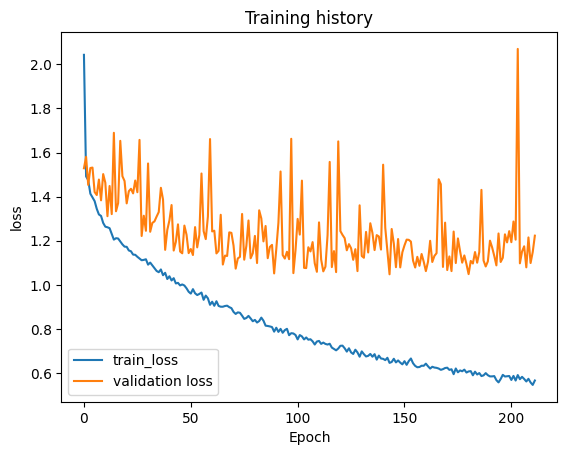

In [130]:
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()


In [131]:
def get_predicted(model, data_loader, loss_fn, device):
    model = model.eval()

    losses = []
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():            
        for test_input, test_label in data_loader:
            test_label = test_label.to(device)
            test_input = test_input.to(device)

            optimizer.zero_grad()

            output_logits, output_softmax = model(test_input.float())

            predictions = torch.argmax(output_softmax,dim=1)
            total_predictions += test_label.size(0)

            correct_predictions += (predictions == test_label).sum().item()

            loss = loss_fn(output_logits, test_label)

            losses.append(loss.item())


        accuracy = correct_predictions / total_predictions
        mean_loss = np.mean(losses)

    return mean_loss, accuracy

In [132]:
loss,prediction=get_predicted(model,test_dataloader,loss_fn,DEVICE)

In [133]:
prediction

0.6517457475380484

In [134]:
loss

1.0261346764034696